### Importación de Tensorflow

In [ ]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Revisamos que CUDA este dispónible en nuestro ambiente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Importación de datos

In [ ]:
! git clone https://github.com/Duchanoy/BolsaDeValores.git

Cloning into 'BolsaDeValores'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 177.33 KiB | 7.39 MiB/s, done.


In [ ]:
!ls
%cd BolsaDeValores
!ls

BolsaDeValores	sample_data
/content/BolsaDeValores
hpq.us.txt  README.md


In [ ]:
date = []
High = []
Low = []
with open('hpq.us.txt', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for i, row in enumerate(spamreader):
        if i == 0:
            print(row)
            print(len(row))
        else:
            date.append(row[0])

            High.append(float(row[2]))
            Low.append(float(row[3]))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
7


In [ ]:
len(date)

12075

### verificando los datos

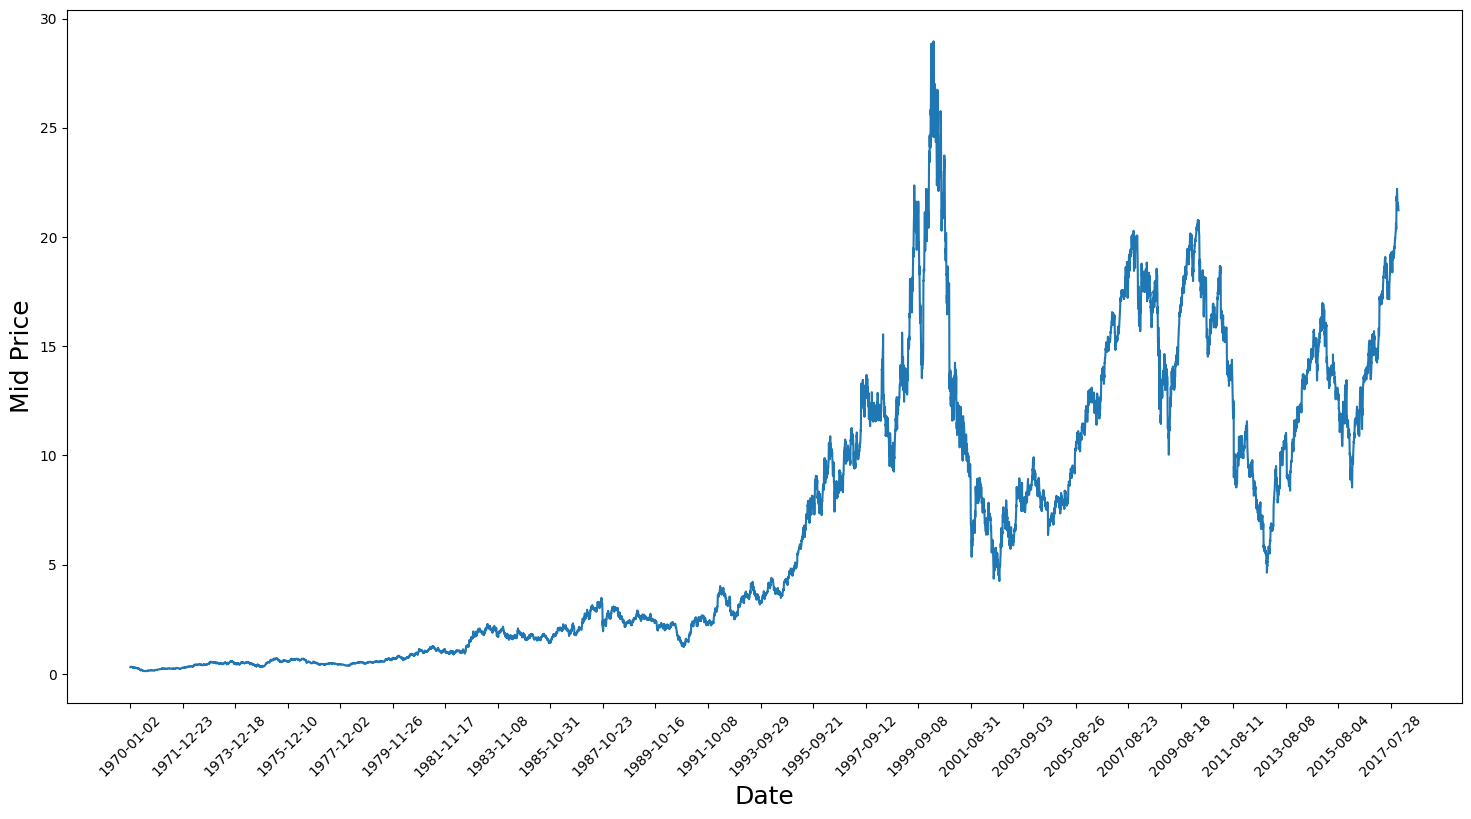

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(range(len(date)), (np.array(Low) + np.array(High)) / 2.0)
plt.xticks(range(0, len(date), 500), date[0::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

In [ ]:
mid_prices = (np.array(Low) + np.array(High)) / 2.0

In [ ]:
Train_data = mid_prices[:11000]
Test_data = mid_prices

In [ ]:
def data_generator_torch(data, window, distance=0):
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data, dtype=torch.float32)

    num_samples = len(data) - window - distance

    indices = torch.arange(num_samples).unsqueeze(1) + torch.arange(window)
    x = data[indices]  # Shape: (num_samples, window)

    # Add feature dimension for RNN: (batch_size, seq_len, input_size)
    x = x.unsqueeze(-1)  # Shape: (num_samples, window, 1)

    # Targets
    target_indices = torch.arange(num_samples) + window + distance
    y = data[target_indices]

    return x, y

In [ ]:
train_x, train_y = data_generator_torch(Train_data, 3, 0)

In [ ]:
print(train_x.shape)
print(train_y.shape)

torch.Size([10997, 3, 1])
torch.Size([10997])


In [ ]:
test_x, test_y = data_generator_torch(Test_data, window=3, distance=0)

In [ ]:
print(test_x.shape)
print(test_y.shape)

torch.Size([12072, 3, 1])
torch.Size([12072])


### Declarando la arquitectura

Generando función

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Optional: Add a linear layer to project to single output for prediction
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Forward pass through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0))

        # Get the last output and apply ReLU (like Keras activation="relu")
        last_output = torch.relu(output[:, -1, :])  # Shape: (batch_size, hidden_size)
        final_h = torch.relu(hn[-1])  # Last layer's hidden state with ReLU
        final_c = cn[-1]  # Last layer's cell state (no activation)

        # For prediction, we can use the linear layer or just one dimension
        prediction = self.linear(last_output).squeeze(-1)  # Shape: (batch_size,)

        # Return: prediction, full_output, state_h, state_c
        return prediction, last_output, final_h, final_c

In [ ]:
model = LSTM(input_size=1, hidden_size=15, num_layers=1)

In [ ]:
# Print model summary
print("Model Architecture:")
print(model)
print("\nModel Parameters:")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Detailed parameter breakdown
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} -> {param.numel()} parameters")

# Parameter calculation explanation:
# For LSTM with input_size=1, hidden_size=10:
# - Input-to-hidden weights: 4 * (input_size * hidden_size) = 4 * (1 * 10) = 40
# - Hidden-to-hidden weights: 4 * (hidden_size * hidden_size) = 4 * (10 * 10) = 400
# - Input-to-hidden bias: 4 * hidden_size = 4 * 10 = 40
# - Hidden-to-hidden bias: 4 * hidden_size = 4 * 10 = 40
# Total: 40 + 400 + 40 + 40 = 520 parameters
#
# Note: The "4" comes from the 4 gates in LSTM (input, forget, output, candidate)

Model Architecture:
LSTM(
  (lstm): LSTM(1, 15, batch_first=True)
  (linear): Linear(in_features=15, out_features=1, bias=True)
)

Model Parameters:
Total parameters: 1096
lstm.weight_ih_l0: torch.Size([60, 1]) -> 60 parameters
lstm.weight_hh_l0: torch.Size([60, 15]) -> 900 parameters
lstm.bias_ih_l0: torch.Size([60]) -> 60 parameters
lstm.bias_hh_l0: torch.Size([60]) -> 60 parameters
linear.weight: torch.Size([1, 15]) -> 15 parameters
linear.bias: torch.Size([1]) -> 1 parameters


## función de prueba

In [ ]:
import torch
import torch.nn as nn


class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        # Add 1 to avoid log(0) issues
        return self.mse(torch.log(pred + 1), torch.log(target + 1))

In [ ]:
def train_model(model, train_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    """
    Train the stock prediction model
    """
    model = model.to(device)
    criterion = MSLELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 50)

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass - only use the output for loss calculation
            prediction, full_output, _, _ = model(data)

            # Calculate loss - prediction shape: (batch_size,), targets shape: (batch_size,)
            loss = criterion(prediction, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {avg_loss:.6f}')

    print("-" * 50)
    print("Training completed!")
    return model

In [ ]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)  # shuffle=False like in Keras
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
trained_model = train_model(model, train_loader, num_epochs=100, learning_rate=0.0015, device=device)

Starting training for 100 epochs...
--------------------------------------------------
Epoch [10/100] - Loss: 0.003250
Epoch [20/100] - Loss: 0.001965
Epoch [30/100] - Loss: 0.001142
Epoch [40/100] - Loss: 0.000902
Epoch [50/100] - Loss: 0.000594
Epoch [60/100] - Loss: 0.000614
Epoch [70/100] - Loss: 0.000550
Epoch [80/100] - Loss: 0.000518
Epoch [90/100] - Loss: 0.000476
Epoch [100/100] - Loss: 0.000521
--------------------------------------------------
Training completed!


In [ ]:
def make_predictions(model, test_loader, device='cpu'):
    """
    Make predictions and return all outputs (prediction, full_output, hidden_state, cell_state)
    """
    model.eval()
    all_predictions = []
    all_outputs = []
    all_hidden_states = []
    all_cell_states = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            prediction, full_output, hidden_state, cell_state = model(data)

            all_predictions.append(prediction.cpu())
            all_outputs.append(full_output.cpu())
            all_hidden_states.append(hidden_state.cpu())
            all_cell_states.append(cell_state.cpu())

    # Concatenate all batches
    predictions = torch.cat(all_predictions, dim=0)
    outputs = torch.cat(all_outputs, dim=0)
    hidden_states = torch.cat(all_hidden_states, dim=0)
    cell_states = torch.cat(all_cell_states, dim=0)

    return predictions, outputs, hidden_states, cell_states

In [ ]:
def visualize_predictions(predictions, outputs, hidden_states, cell_states, mid_prices, dates, hidden_size=10):
    """
    Visualize predictions, hidden states, and cell states
    """
    # Convert to numpy for plotting
    predictions_np = predictions.numpy()
    outputs_np = outputs.numpy()
    hidden_states_np = hidden_states.numpy()
    cell_states_np = cell_states.numpy()

    # Plot main predictions first
    print("Main Stock Price Predictions:")
    print("=" * 100)
    plt.figure(figsize=(18, 9))
    plt.plot(range(len(dates[3:])), mid_prices[3:], label='Actual Price', alpha=0.8)
    plt.plot(range(len(dates[3:])), predictions_np, color="green", label='LSTM Predictions', alpha=0.8, linewidth=2)
    plt.xticks(range(0, len(dates), 500), dates[0::500], rotation=45)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Mid Price', fontsize=18)
    plt.title('Stock Price Prediction - Main Output', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot predictions for each output dimension (LSTM hidden state outputs)
    print("\nVisualizing LSTM Output Dimensions...")
    for i in range(hidden_size):
        print(
            f"**************************************************************************************************************************************************************")
        print(f"            Predicciones No. {i}")
        print(
            f"**************************************************************************************************************************************************************")

        projections = outputs_np[:, i]

        plt.figure(figsize=(18, 9))
        plt.plot(range(len(dates[3:])), mid_prices[3:], label='Actual Price', alpha=0.7)
        plt.plot(range(len(dates[3:])), projections, color="green", label=f'LSTM Output {i}', alpha=0.7)
        plt.xticks(range(0, len(dates), 500), dates[0::500], rotation=45)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Value', fontsize=18)
        plt.title(f'LSTM Output Dimension {i}', fontsize=16)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot hidden states
    print("\nVisualizing Hidden States...")
    for i in range(hidden_size):
        print(
            f"**************************************************************************************************************************************************************")
        print(f"            Estado oculto No. {i}")
        print(
            f"**************************************************************************************************************************************************************")

        projections = hidden_states_np[:, i]

        plt.figure(figsize=(18, 9))
        plt.plot(range(len(dates[3:])), mid_prices[3:], label='Actual Price', alpha=0.7)
        plt.plot(range(len(dates[3:])), projections, color="green", label=f'Hidden State {i}', alpha=0.7)
        plt.xticks(range(0, len(dates), 500), dates[0::500], rotation=45)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Value', fontsize=18)
        plt.title(f'Hidden State Visualization - Dimension {i}', fontsize=16)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot cell states
    print("\nVisualizing Cell States...")
    for i in range(hidden_size):
        print(
            f"**************************************************************************************************************************************************************")
        print(f"            Estado carry No. {i}")
        print(
            f"**************************************************************************************************************************************************************")

        projections = cell_states_np[:, i]

        plt.figure(figsize=(18, 9))
        plt.plot(range(len(dates[3:])), mid_prices[3:], label='Actual Price', alpha=0.7)
        plt.plot(range(len(dates[3:])), projections, color="green", label=f'Cell State {i}', alpha=0.7)
        plt.xticks(range(0, len(dates), 500), dates[0::500], rotation=45)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Value', fontsize=18)
        plt.title(f'Cell State Visualization - Dimension {i}', fontsize=16)
        plt.legend()
        plt.tight_layout()
        plt.show()



Making predictions...
Outputs shape: torch.Size([12072, 15])
Hidden states shape: torch.Size([12072, 15])
Cell states shape: torch.Size([12072, 15])
Main Stock Price Predictions:


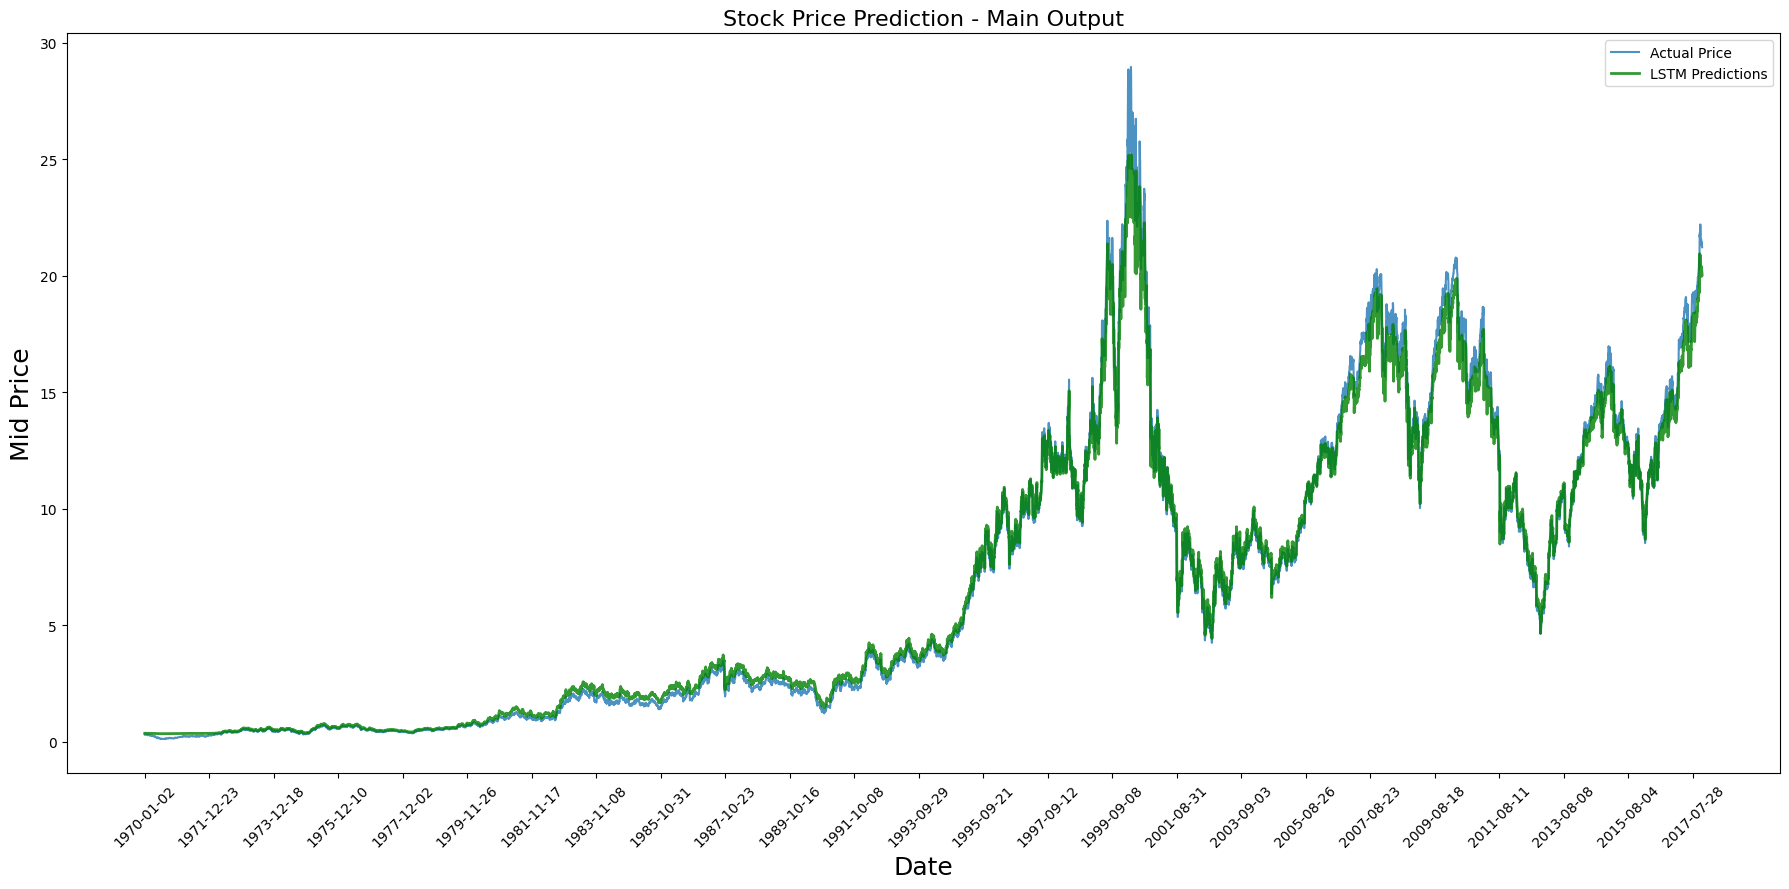


Visualizing LSTM Output Dimensions...
**************************************************************************************************************************************************************
            Predicciones No. 0
**************************************************************************************************************************************************************


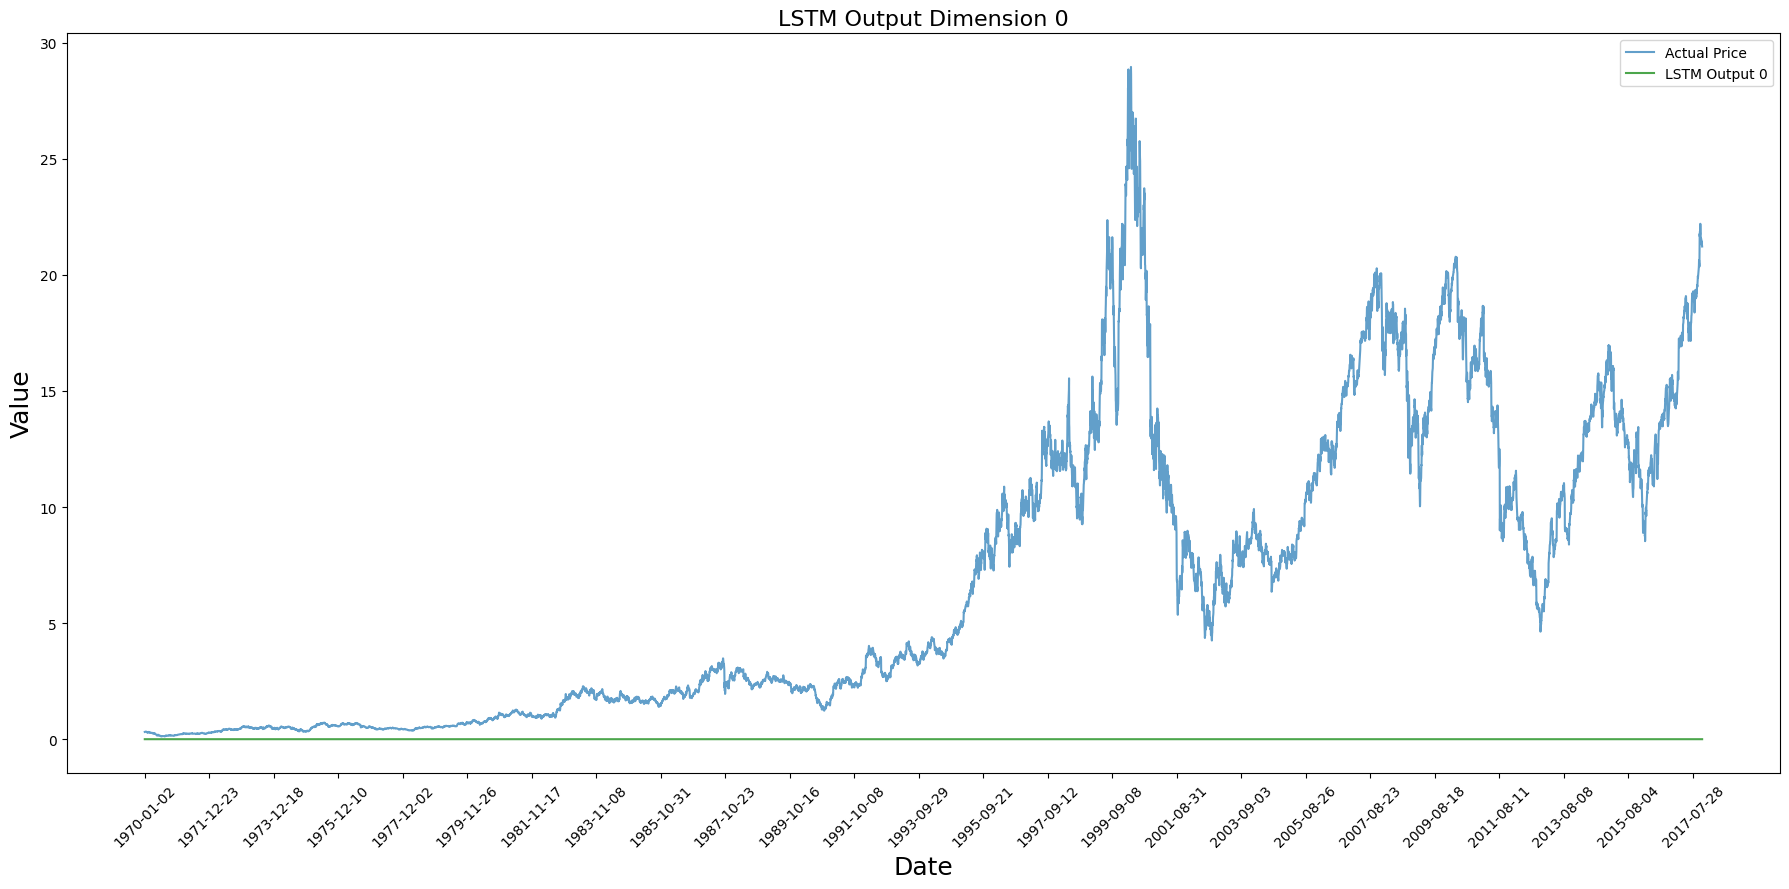

**************************************************************************************************************************************************************
            Predicciones No. 1
**************************************************************************************************************************************************************


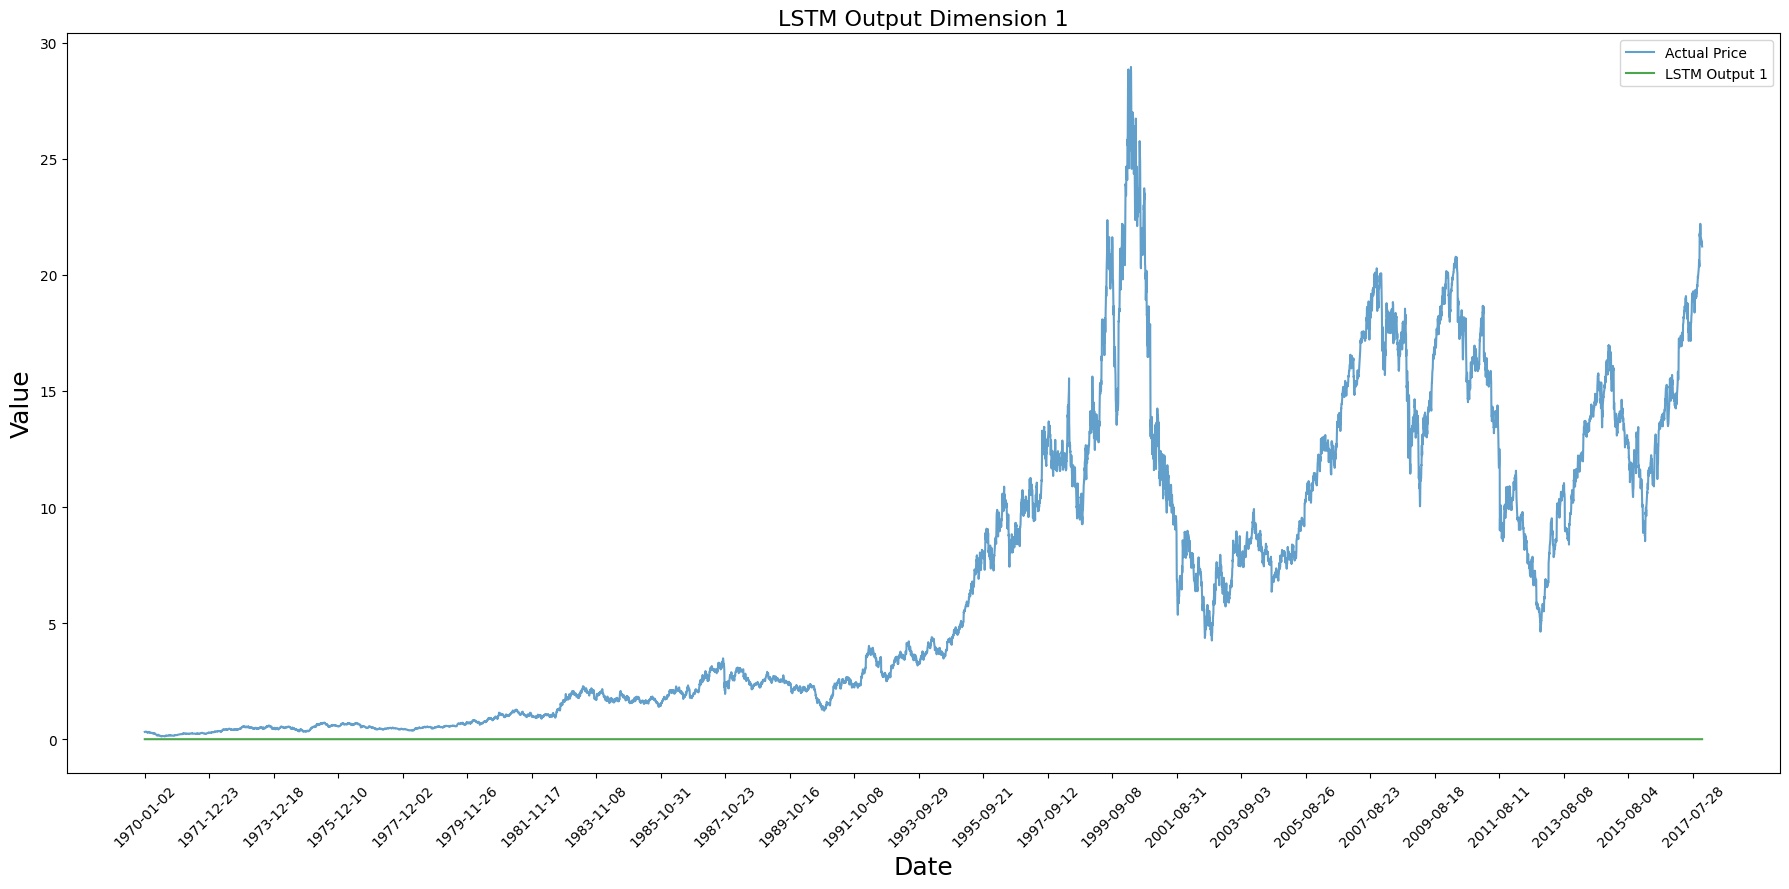

**************************************************************************************************************************************************************
            Predicciones No. 2
**************************************************************************************************************************************************************


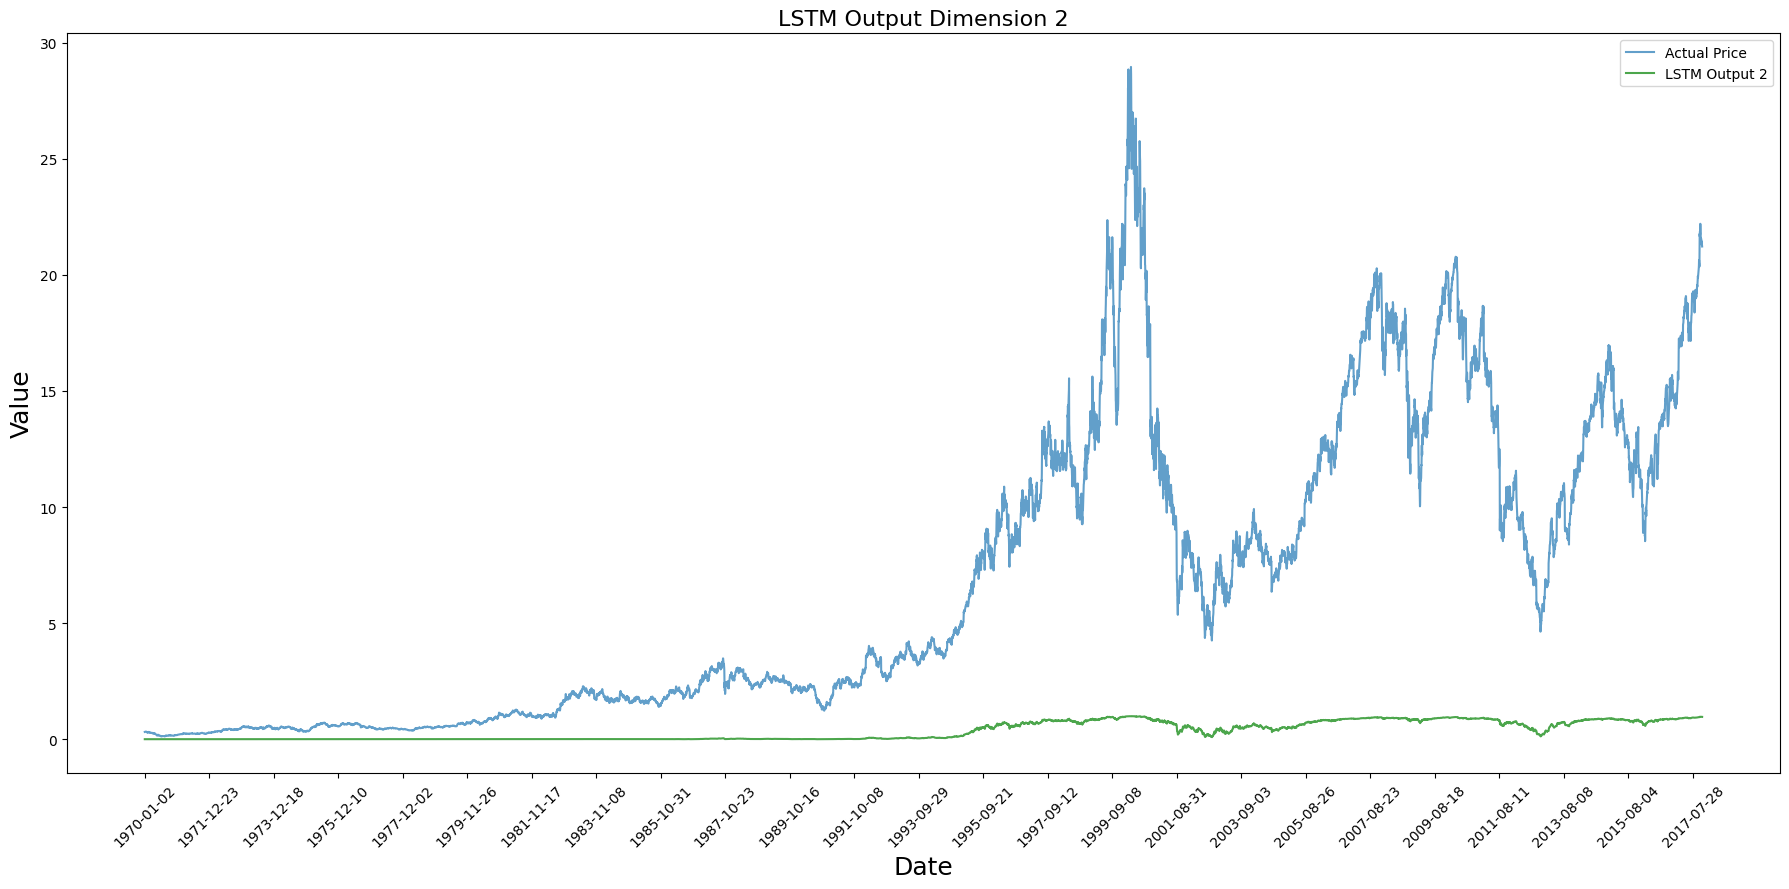

**************************************************************************************************************************************************************
            Predicciones No. 3
**************************************************************************************************************************************************************


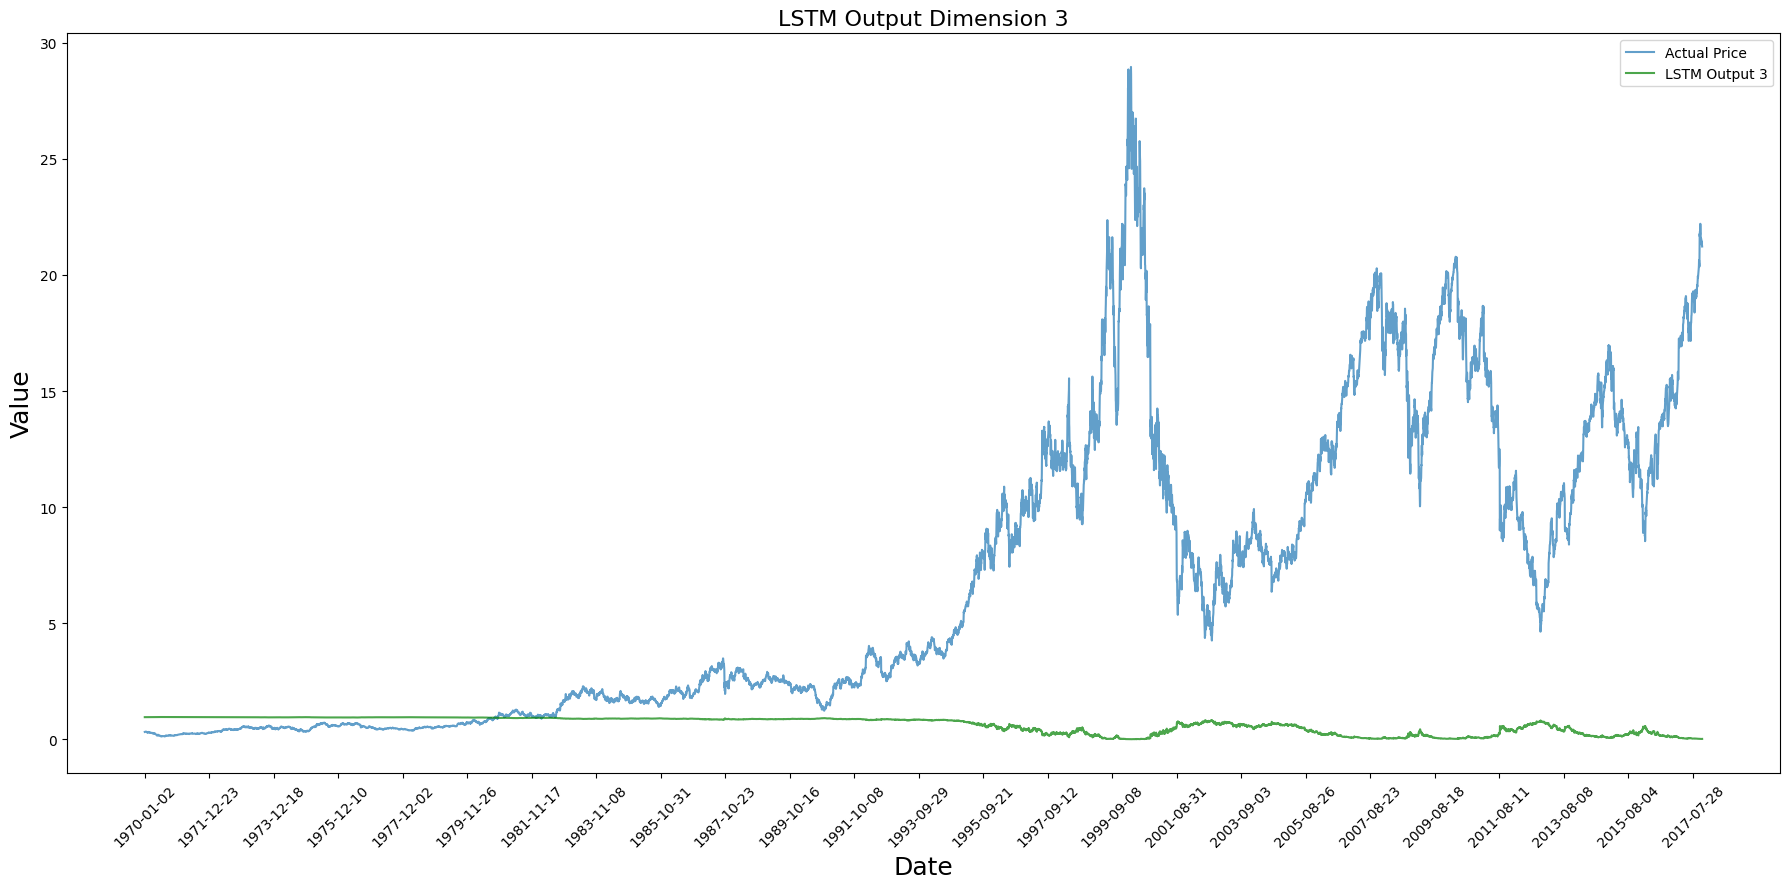

**************************************************************************************************************************************************************
            Predicciones No. 4
**************************************************************************************************************************************************************


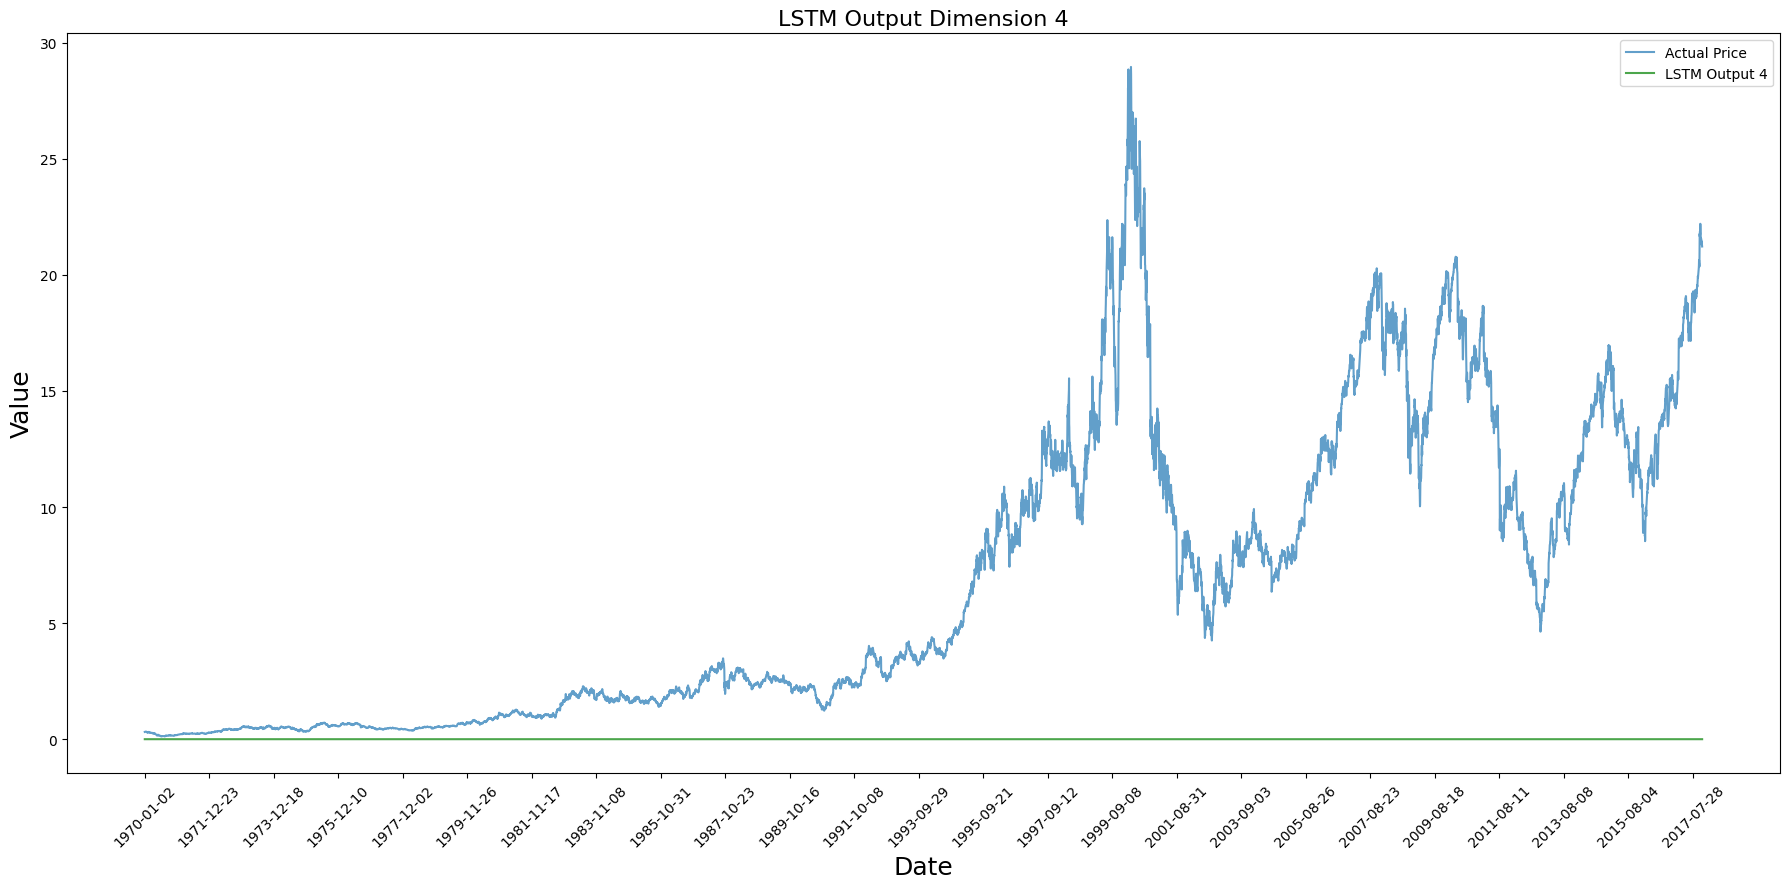

**************************************************************************************************************************************************************
            Predicciones No. 5
**************************************************************************************************************************************************************


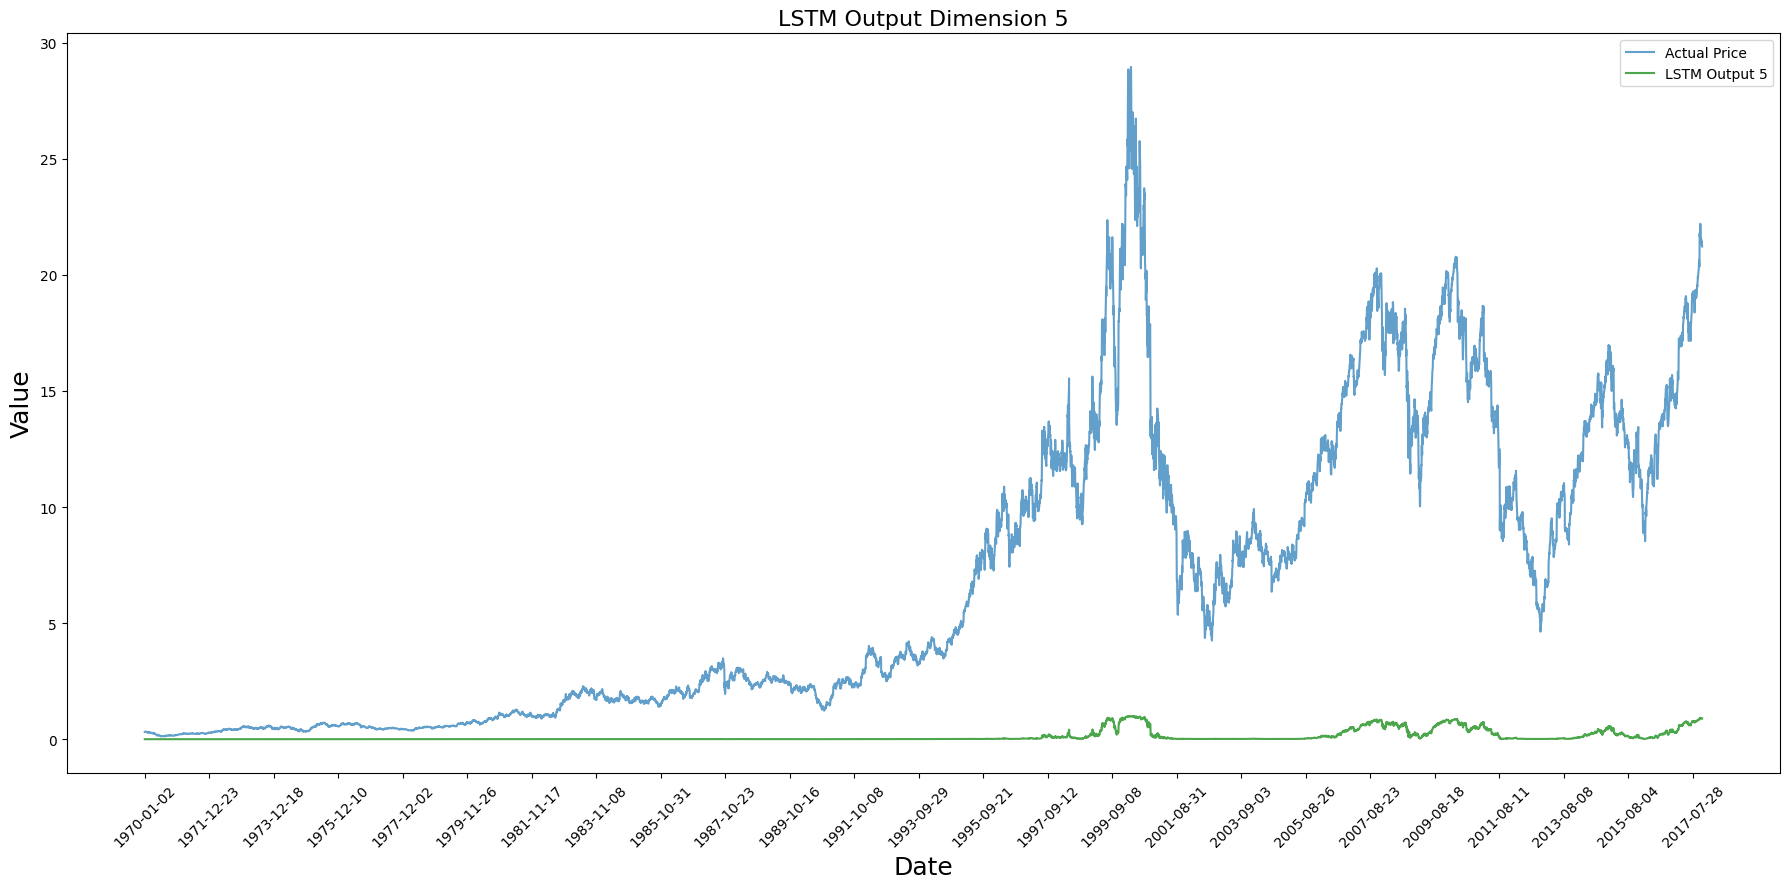

**************************************************************************************************************************************************************
            Predicciones No. 6
**************************************************************************************************************************************************************


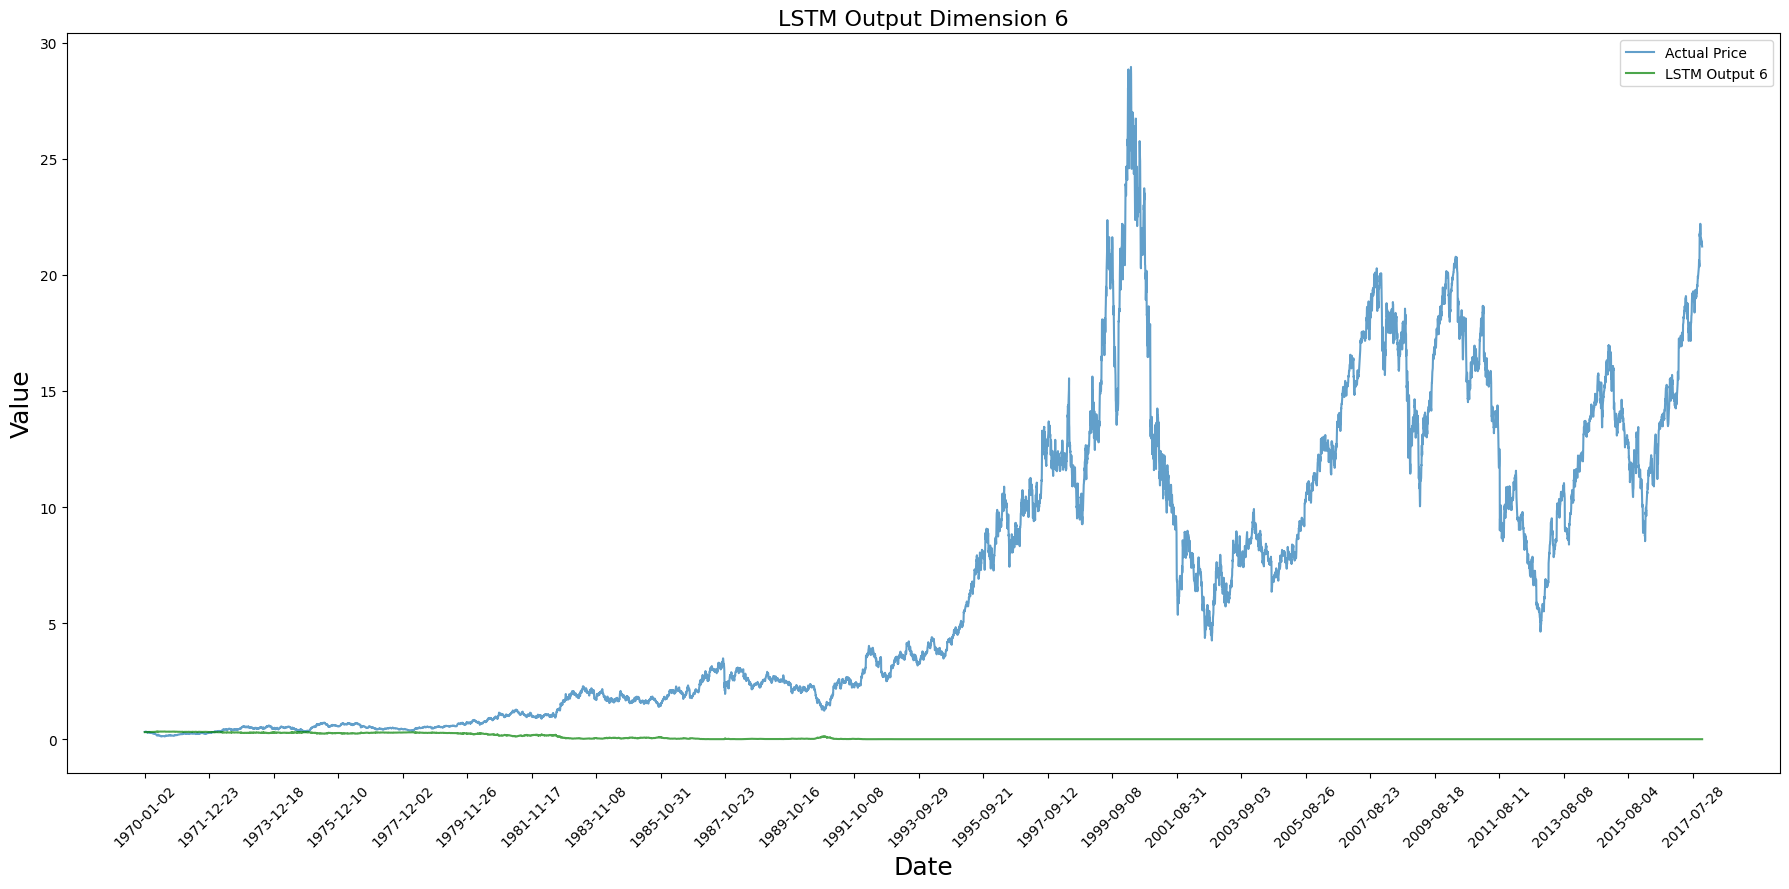

**************************************************************************************************************************************************************
            Predicciones No. 7
**************************************************************************************************************************************************************


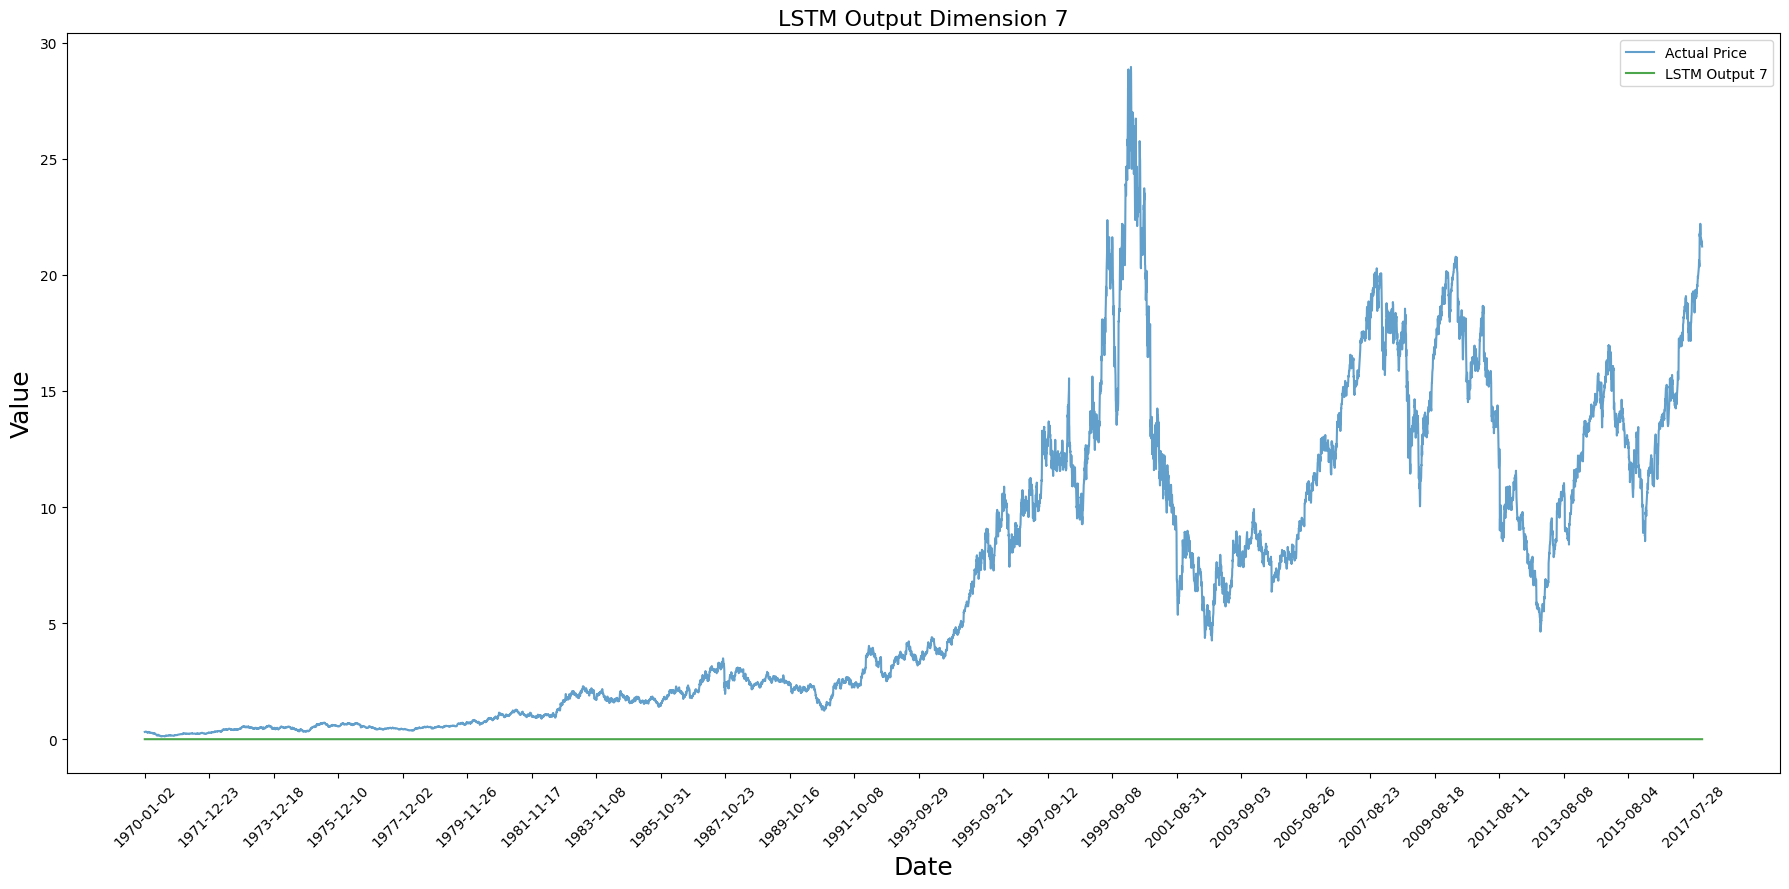

**************************************************************************************************************************************************************
            Predicciones No. 8
**************************************************************************************************************************************************************


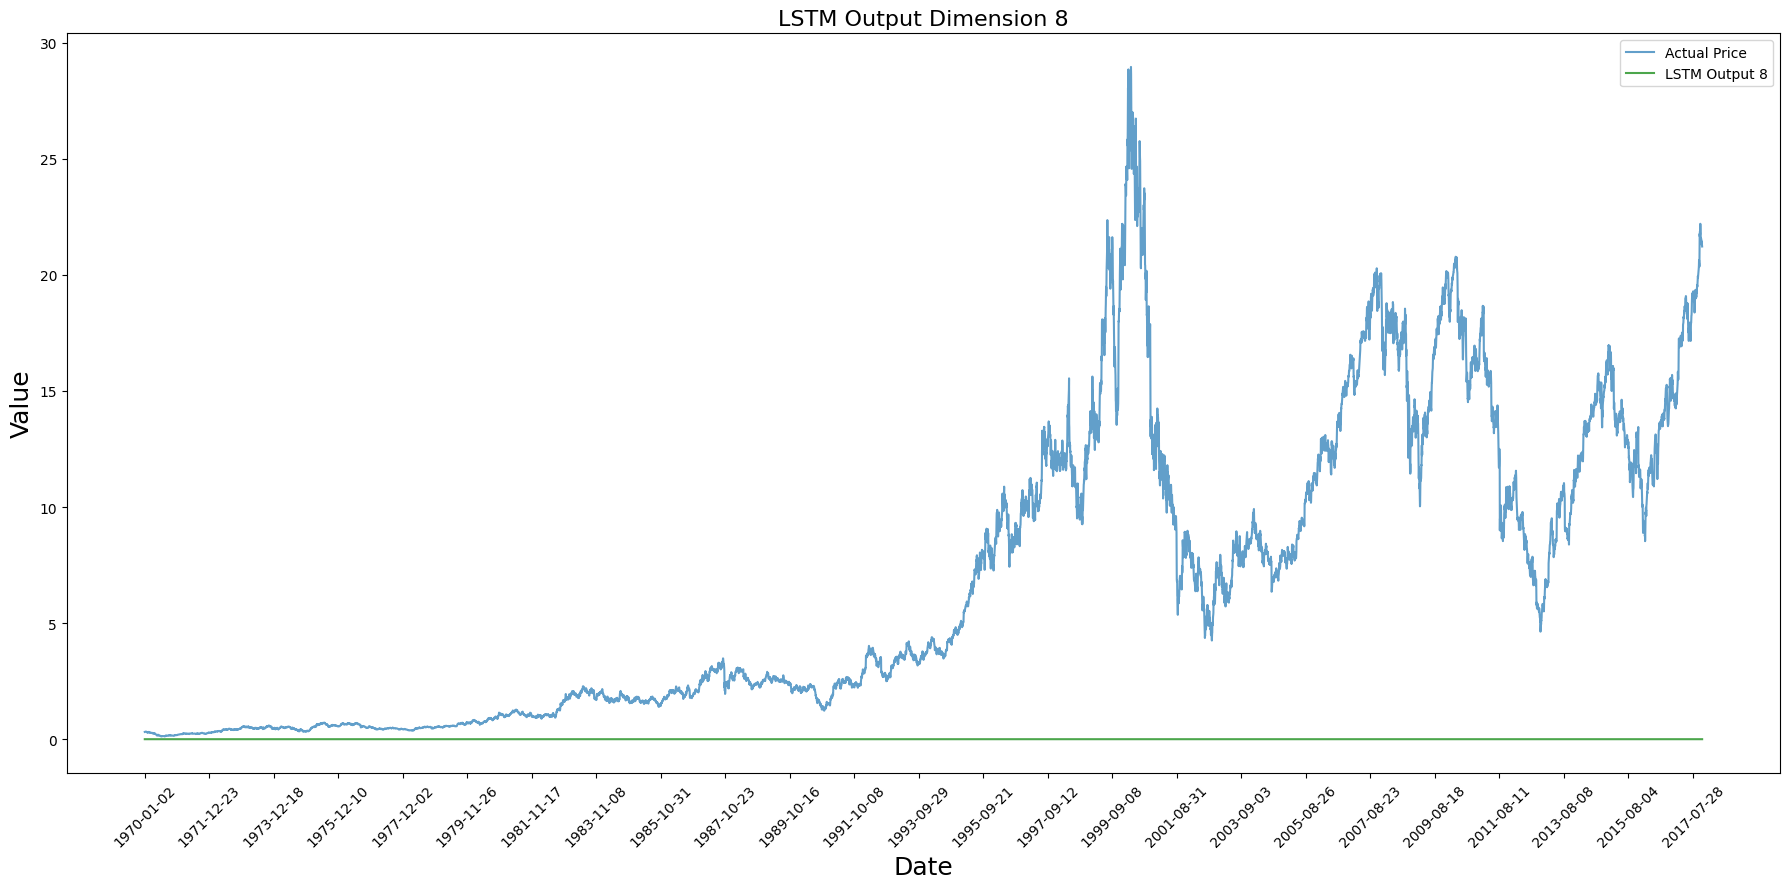

**************************************************************************************************************************************************************
            Predicciones No. 9
**************************************************************************************************************************************************************


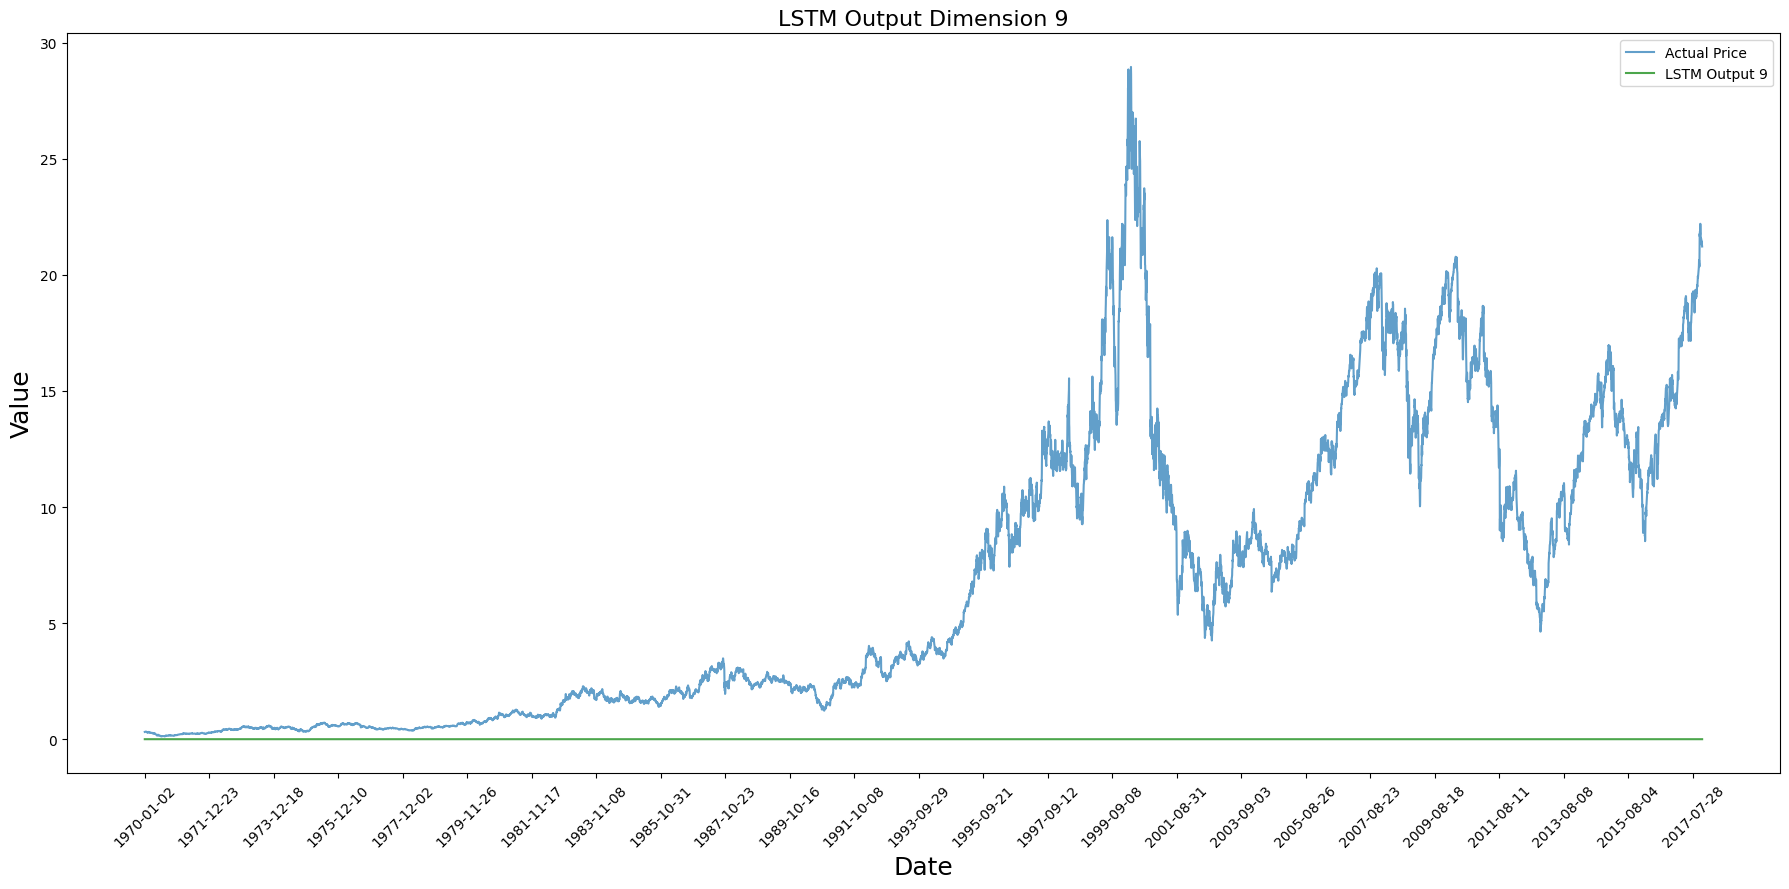


Visualizing Hidden States...
**************************************************************************************************************************************************************
            Estado oculto No. 0
**************************************************************************************************************************************************************


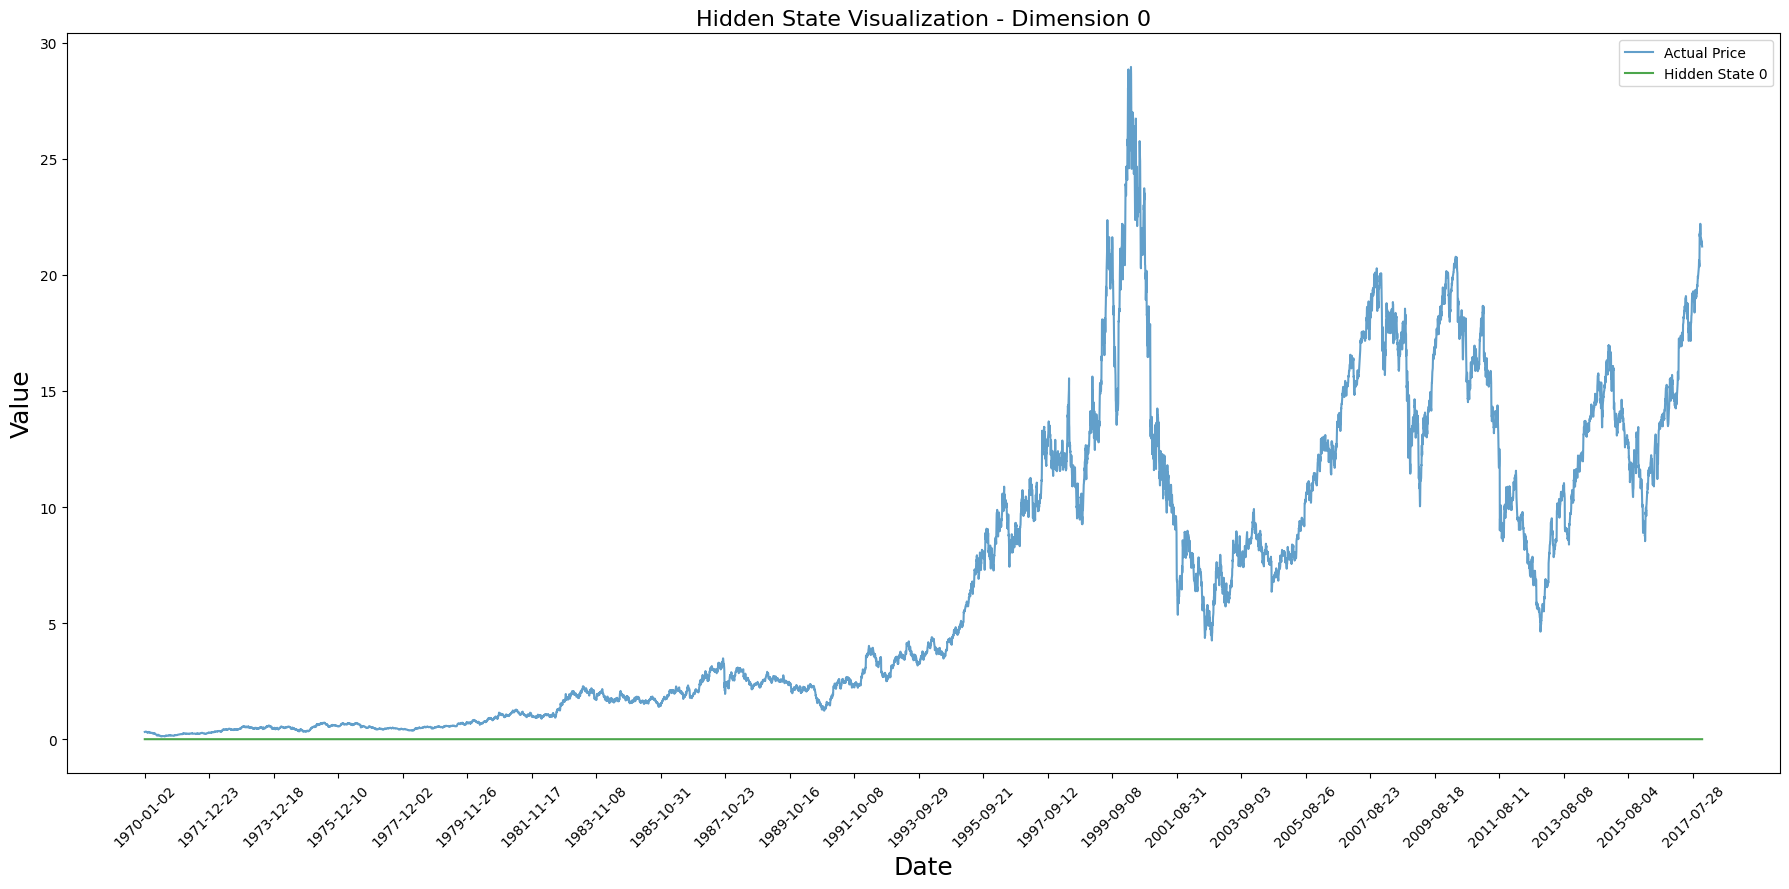

**************************************************************************************************************************************************************
            Estado oculto No. 1
**************************************************************************************************************************************************************


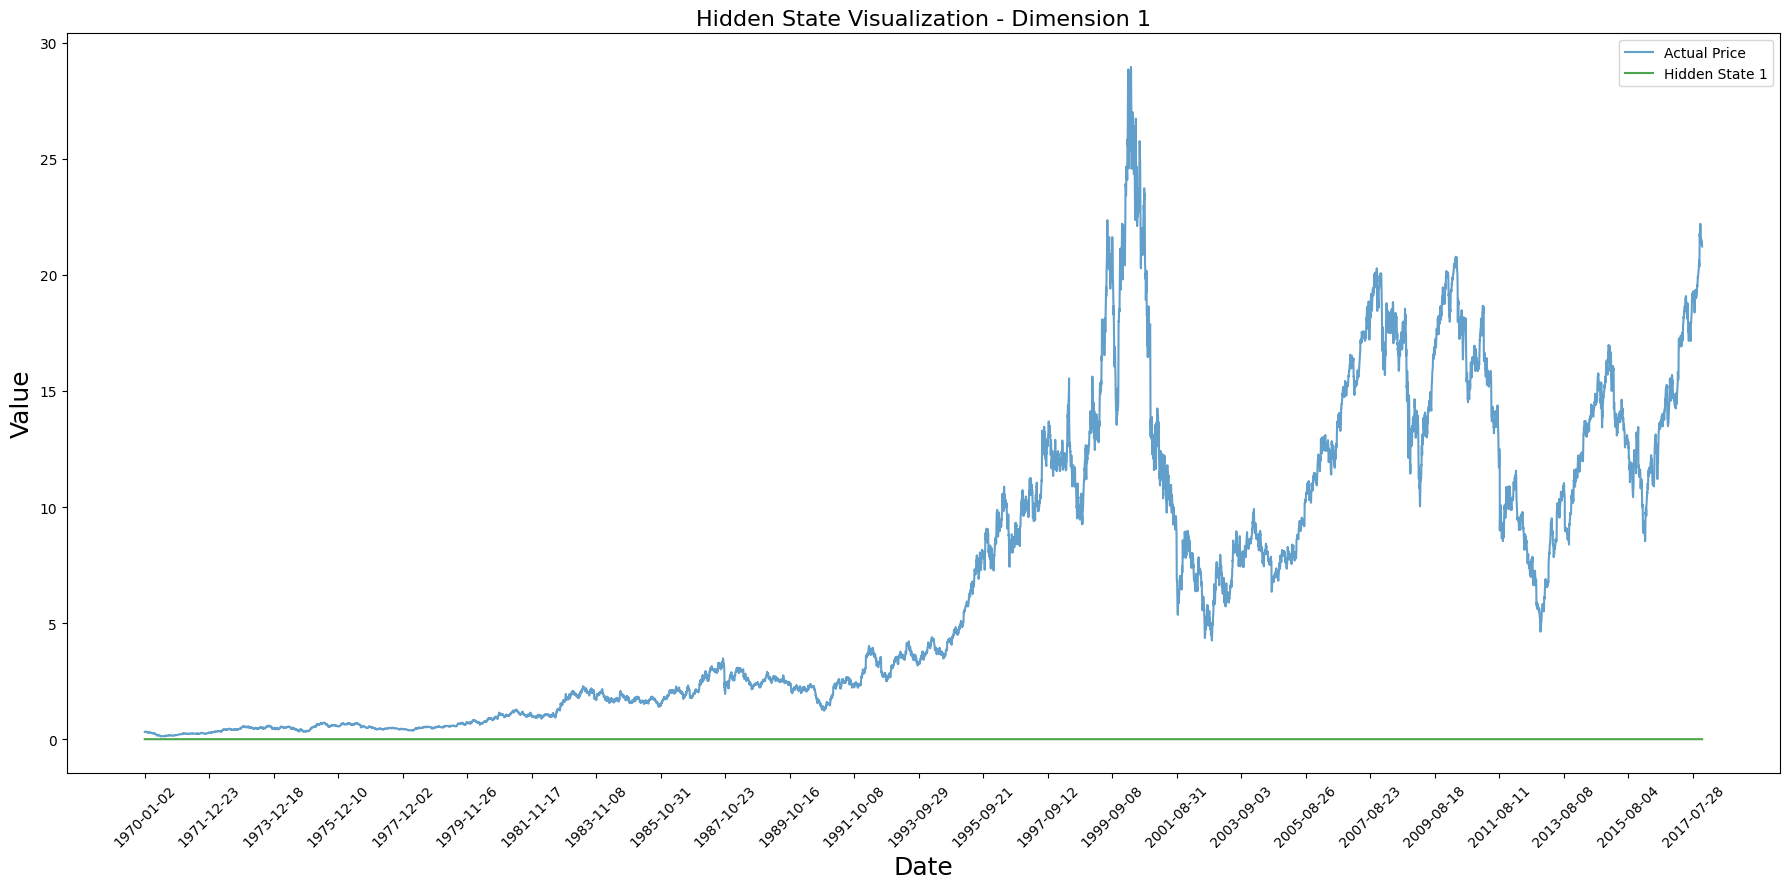

**************************************************************************************************************************************************************
            Estado oculto No. 2
**************************************************************************************************************************************************************


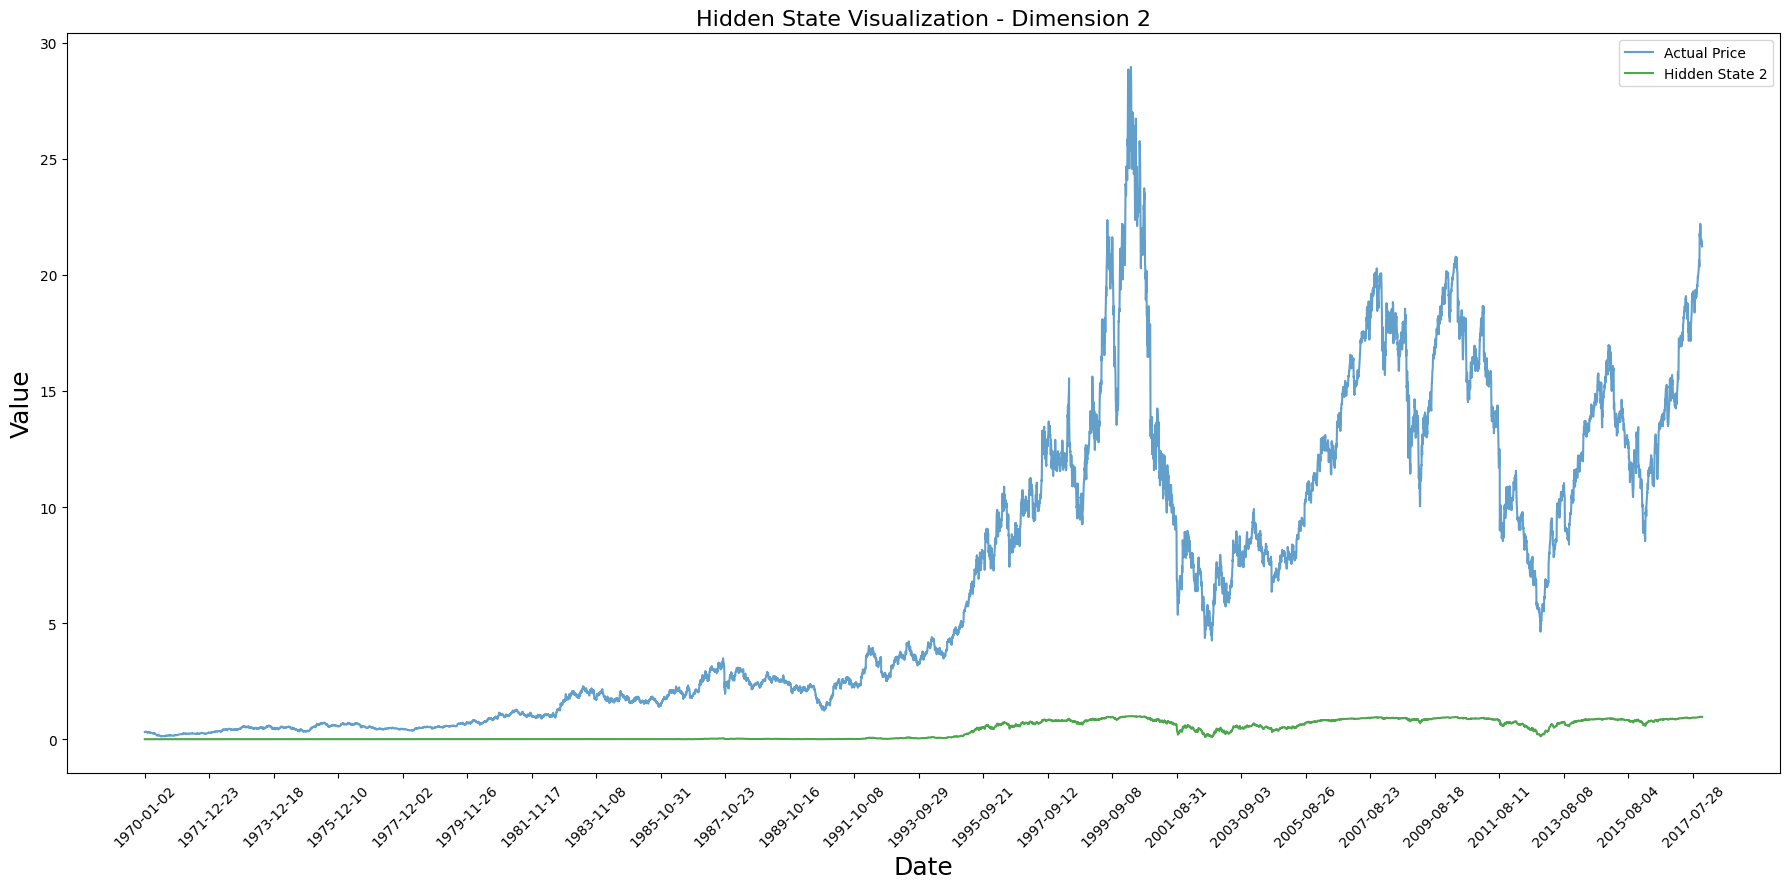

**************************************************************************************************************************************************************
            Estado oculto No. 3
**************************************************************************************************************************************************************


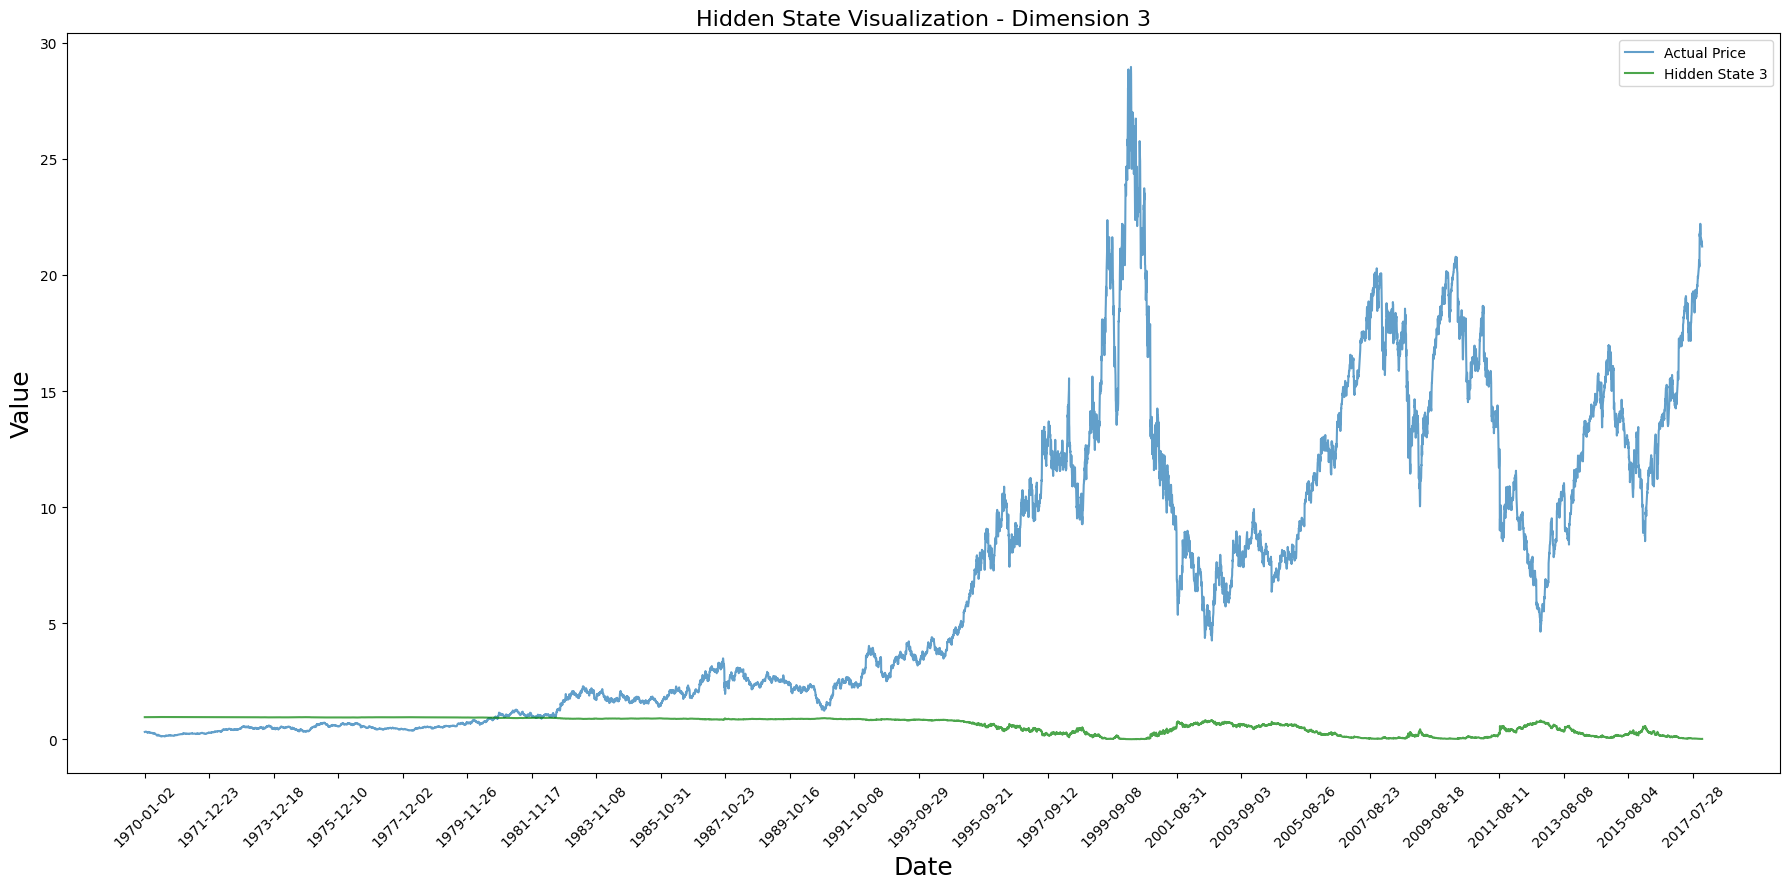

**************************************************************************************************************************************************************
            Estado oculto No. 4
**************************************************************************************************************************************************************


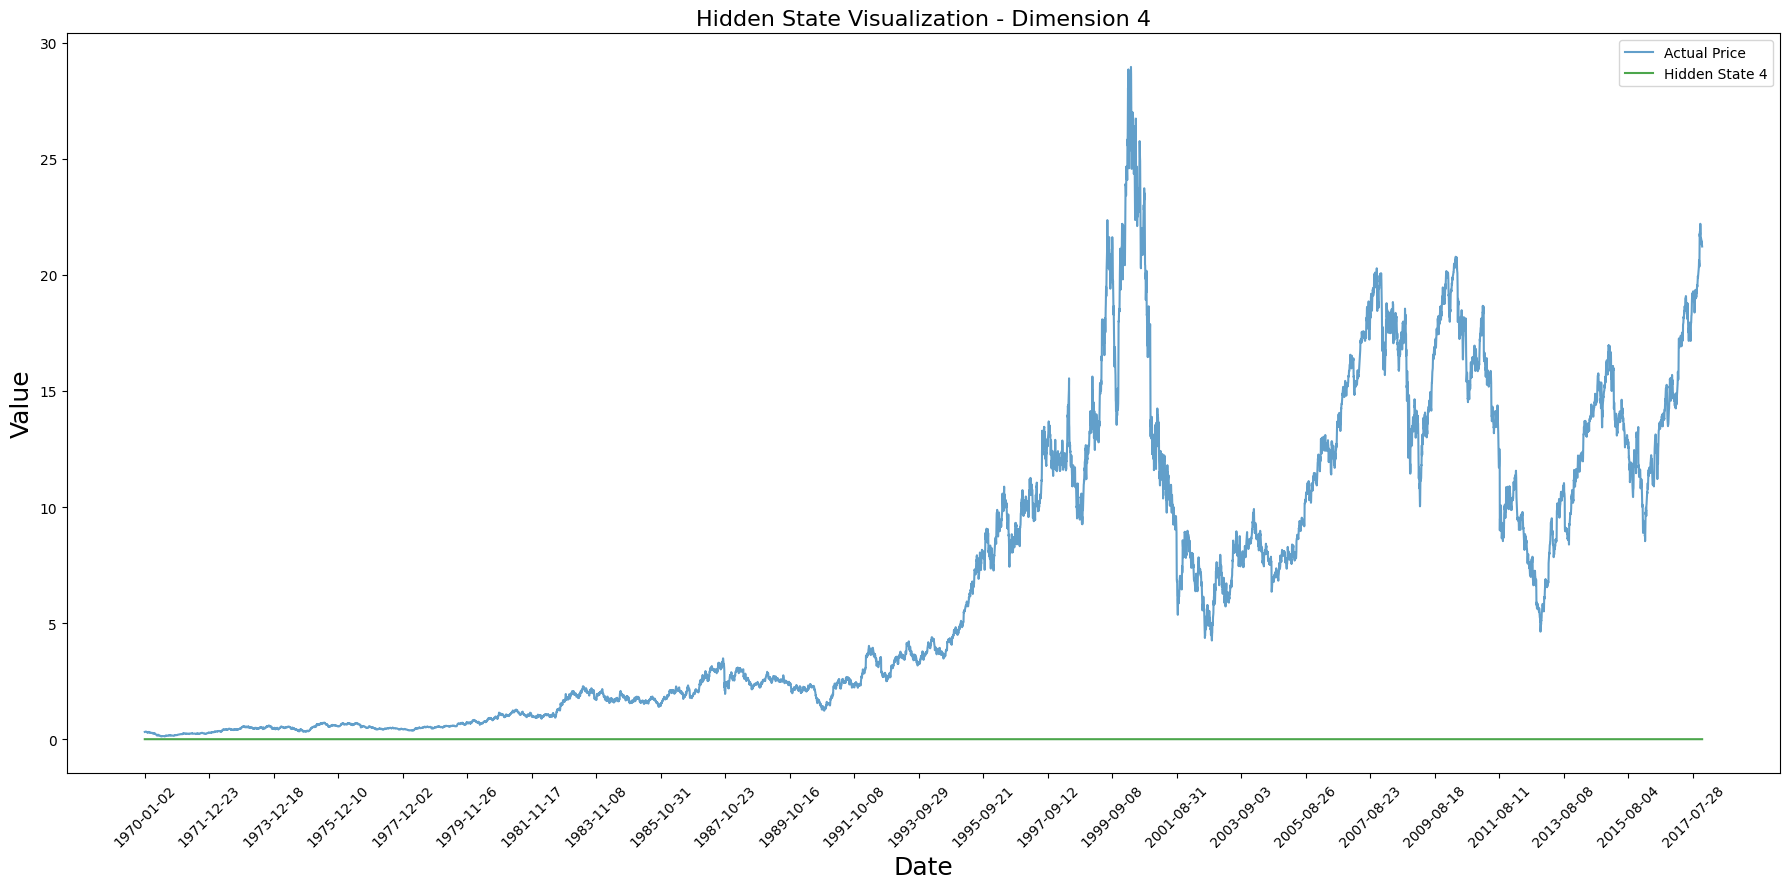

**************************************************************************************************************************************************************
            Estado oculto No. 5
**************************************************************************************************************************************************************


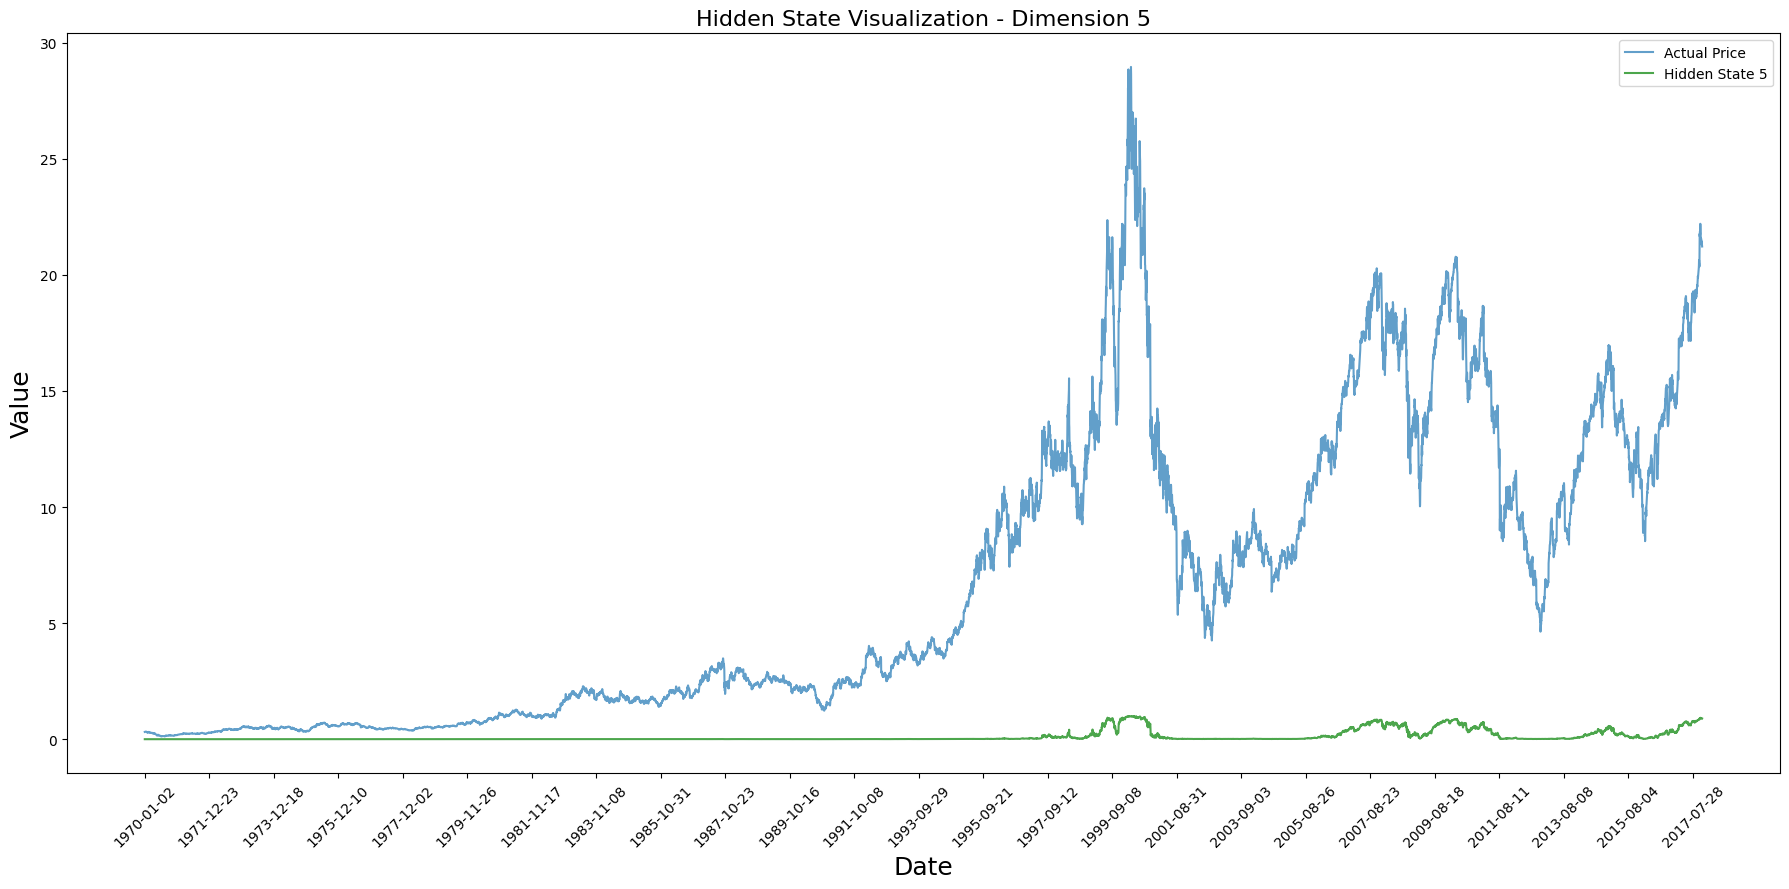

**************************************************************************************************************************************************************
            Estado oculto No. 6
**************************************************************************************************************************************************************


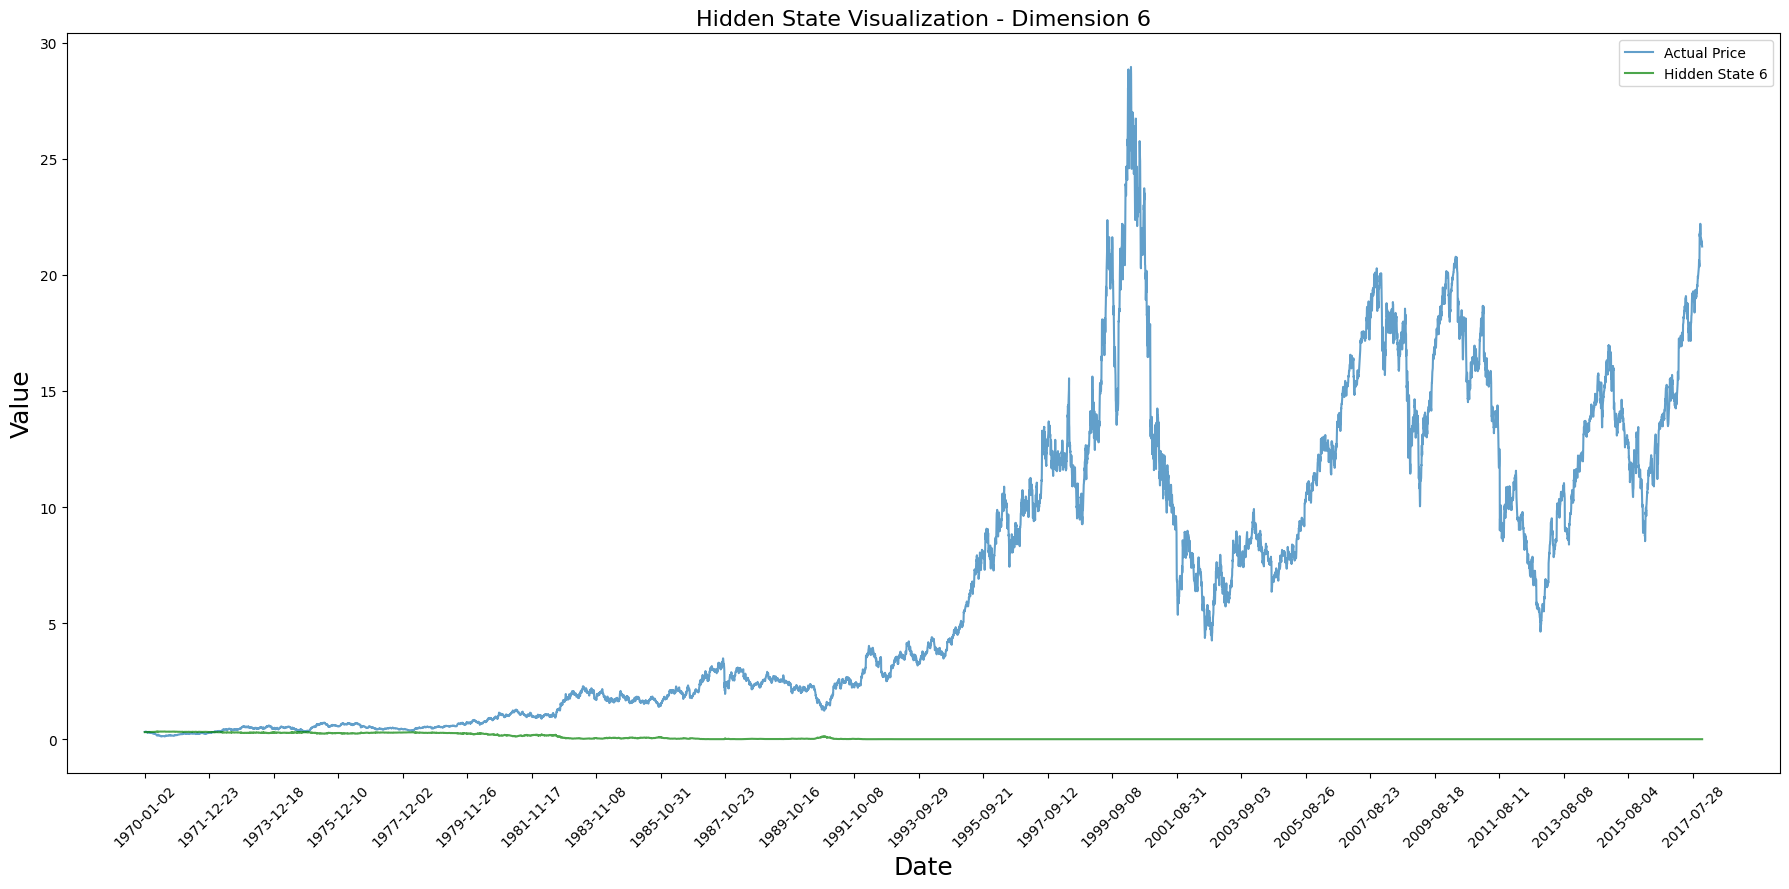

**************************************************************************************************************************************************************
            Estado oculto No. 7
**************************************************************************************************************************************************************


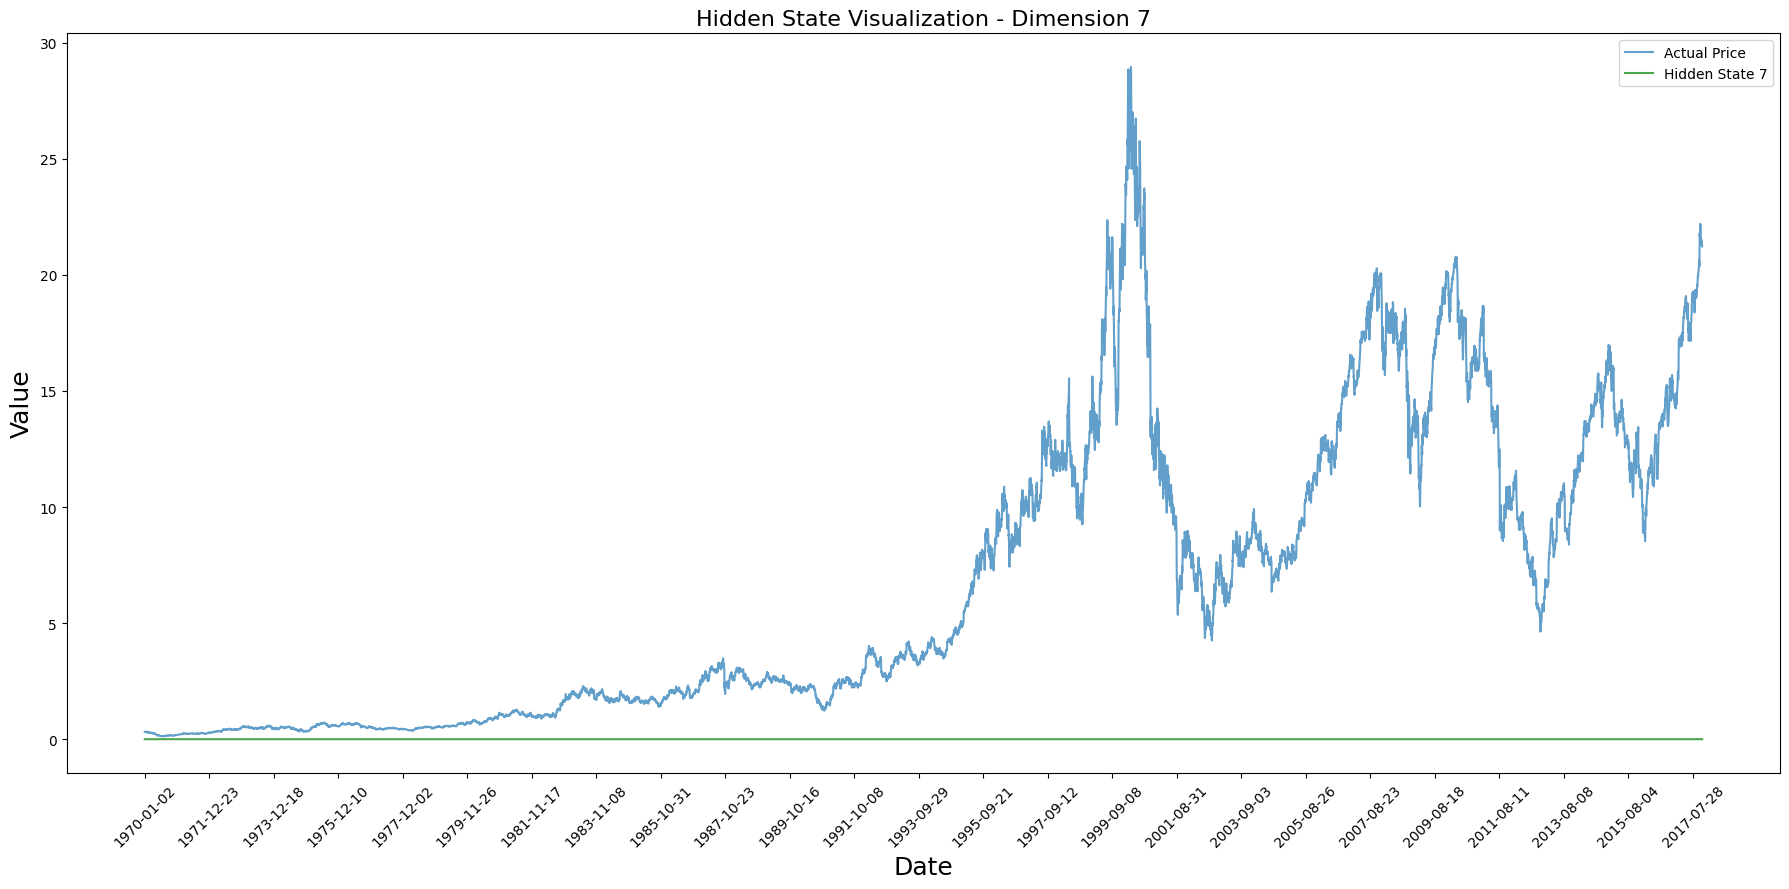

**************************************************************************************************************************************************************
            Estado oculto No. 8
**************************************************************************************************************************************************************


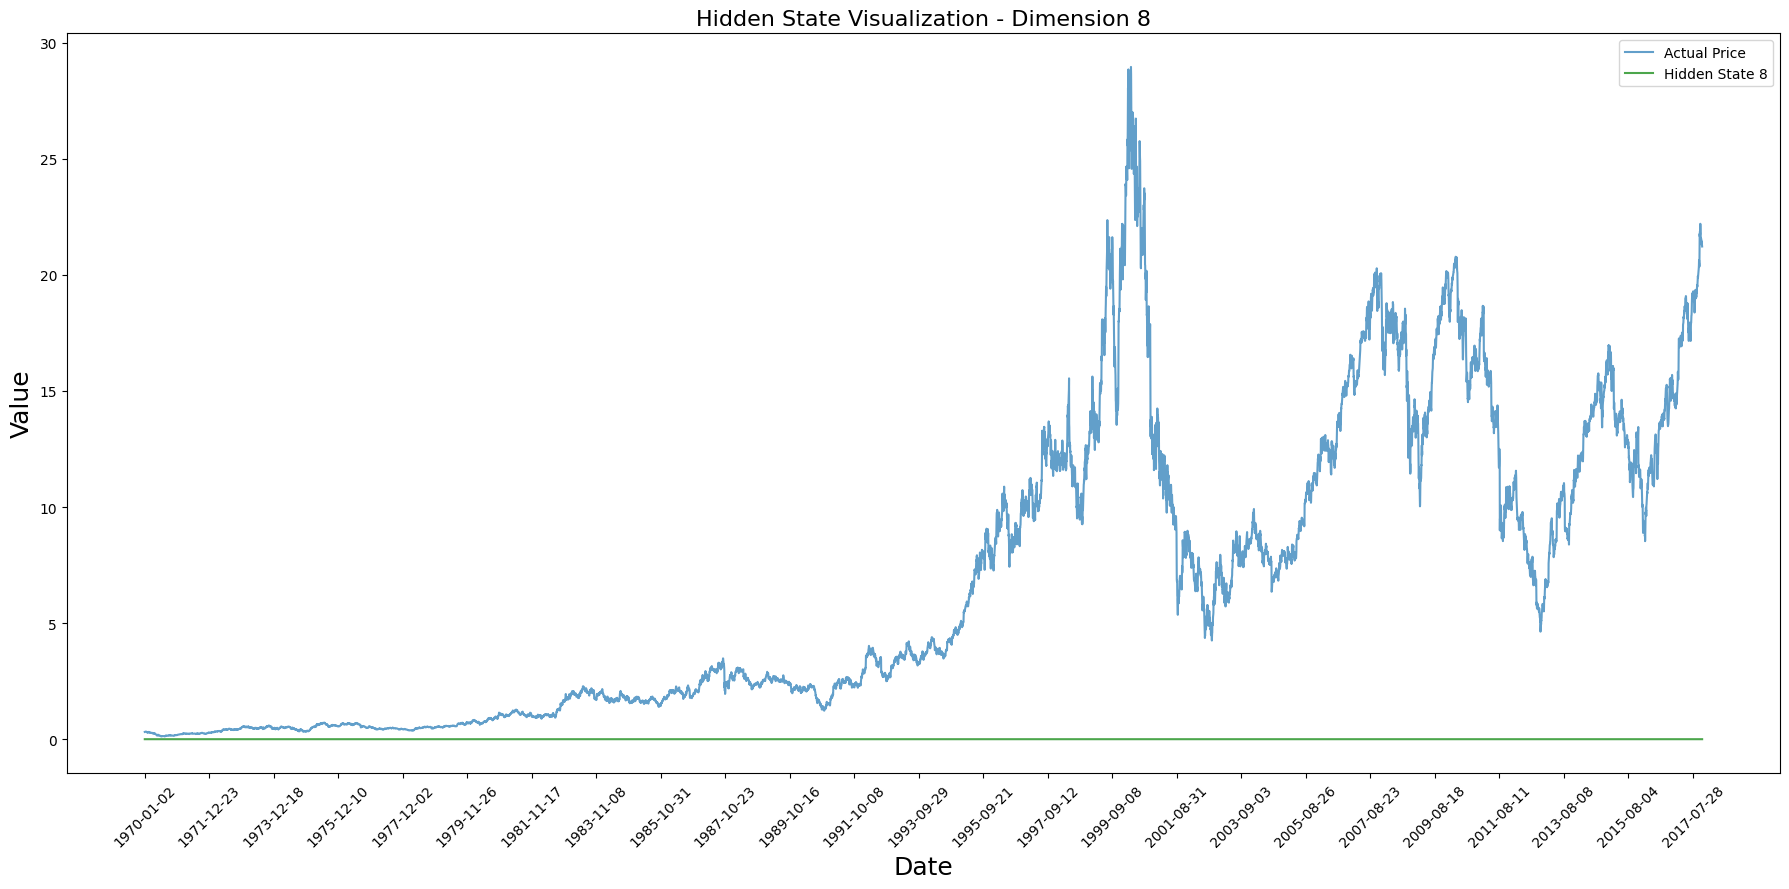

**************************************************************************************************************************************************************
            Estado oculto No. 9
**************************************************************************************************************************************************************


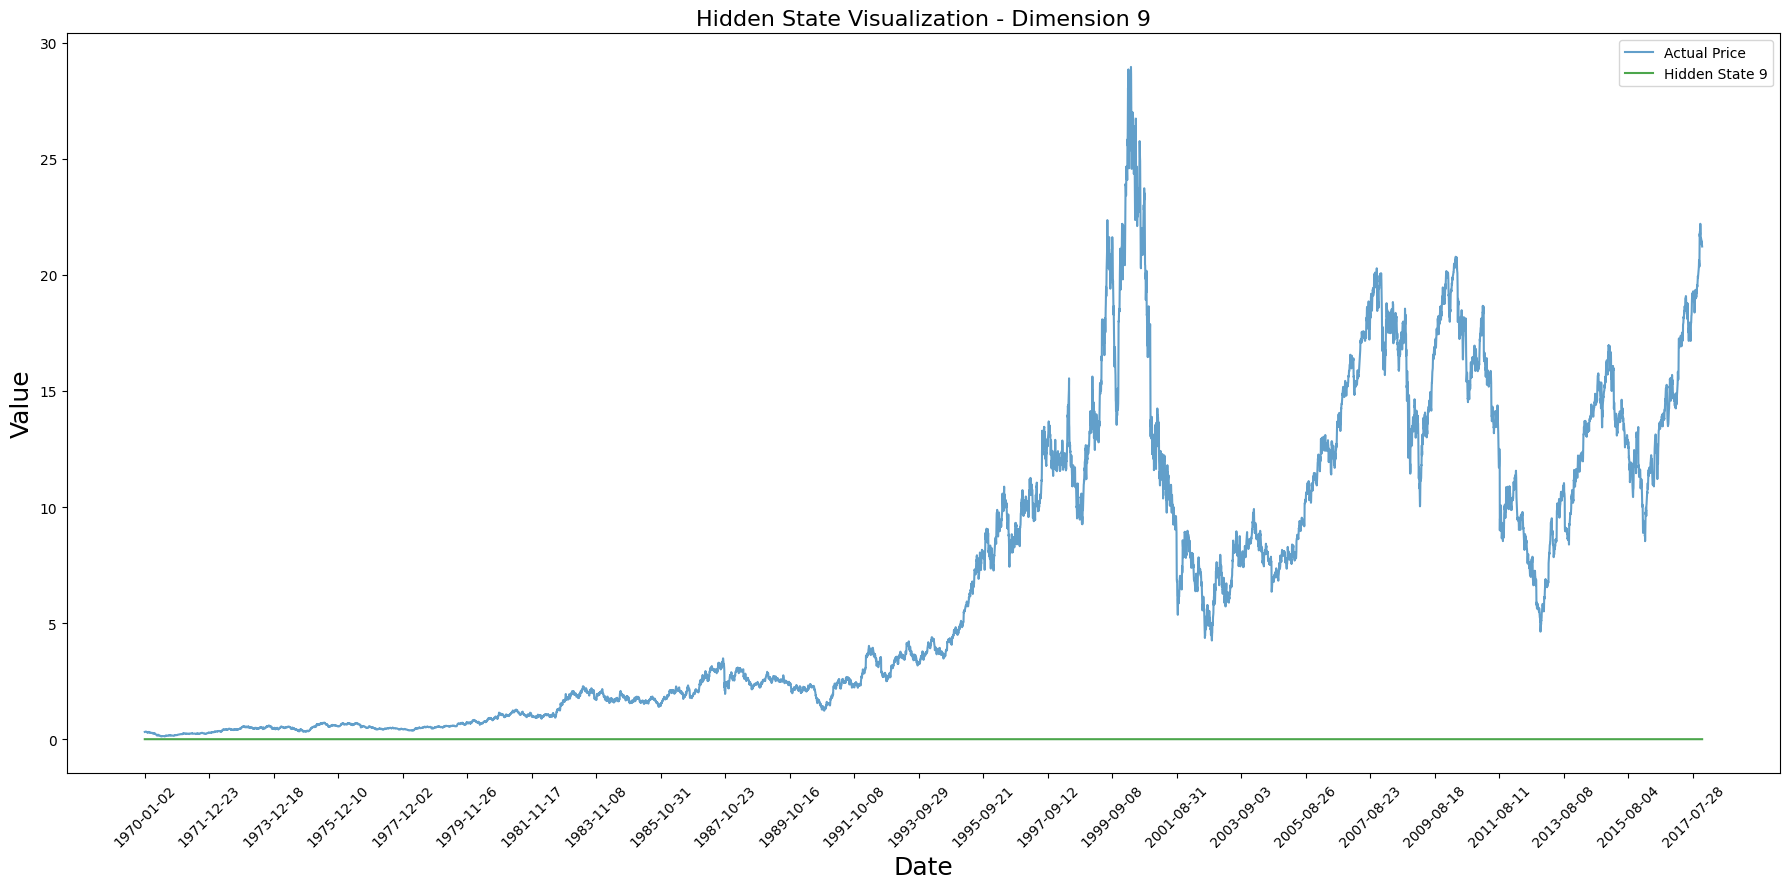


Visualizing Cell States...
**************************************************************************************************************************************************************
            Estado carry No. 0
**************************************************************************************************************************************************************


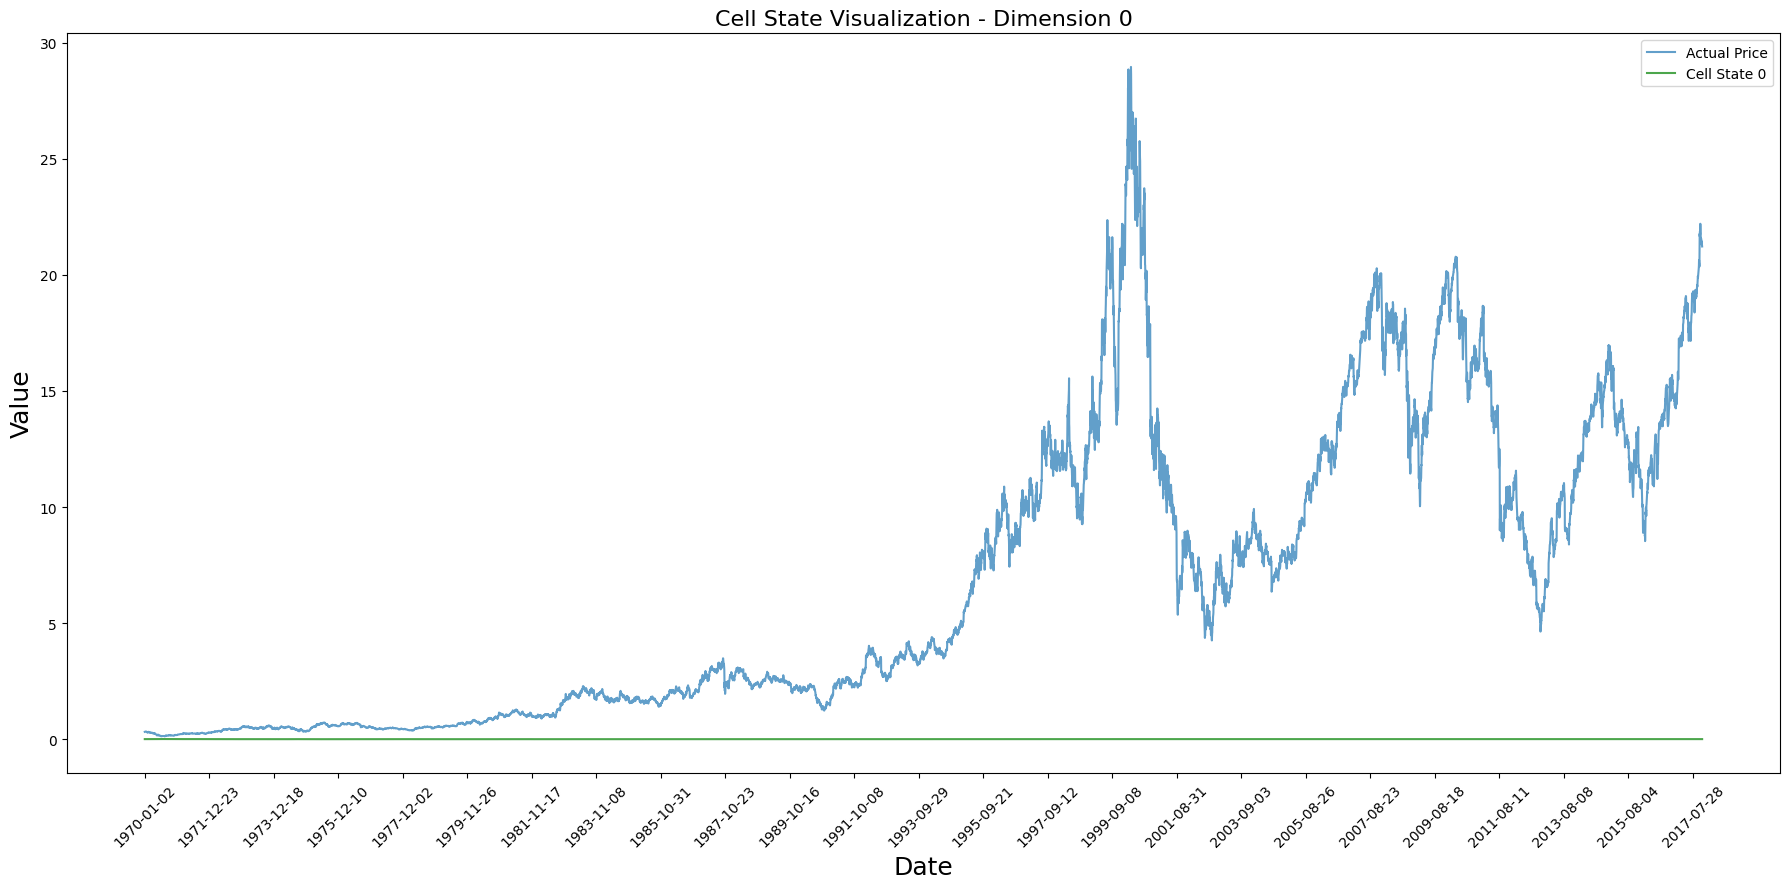

**************************************************************************************************************************************************************
            Estado carry No. 1
**************************************************************************************************************************************************************


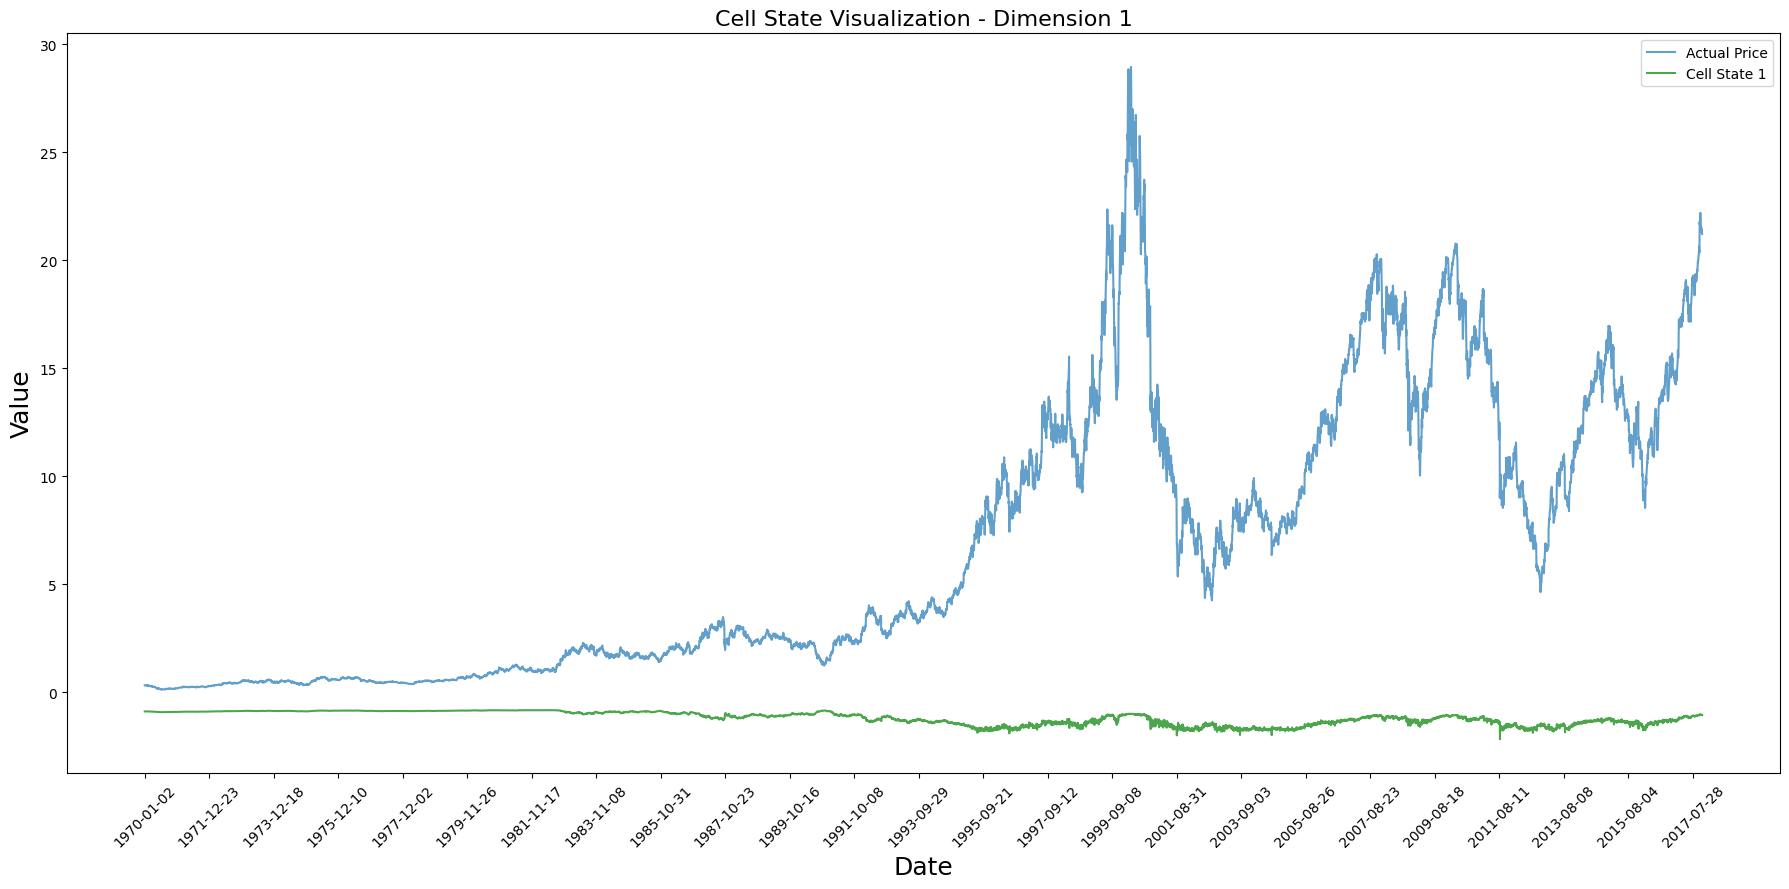

**************************************************************************************************************************************************************
            Estado carry No. 2
**************************************************************************************************************************************************************


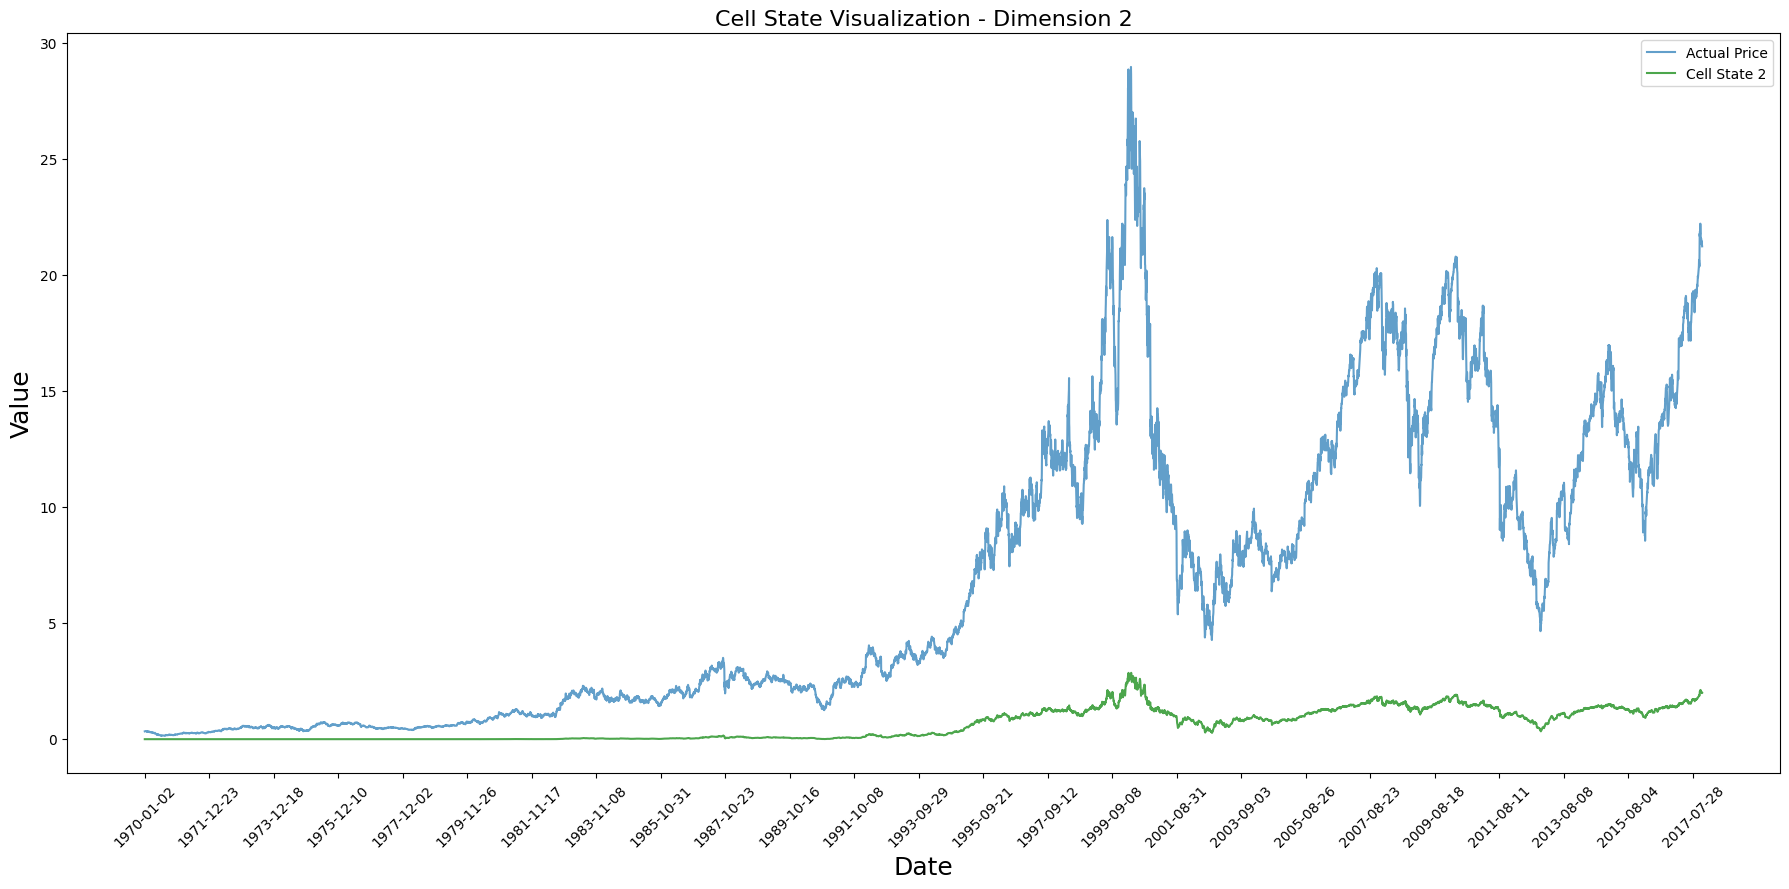

**************************************************************************************************************************************************************
            Estado carry No. 3
**************************************************************************************************************************************************************


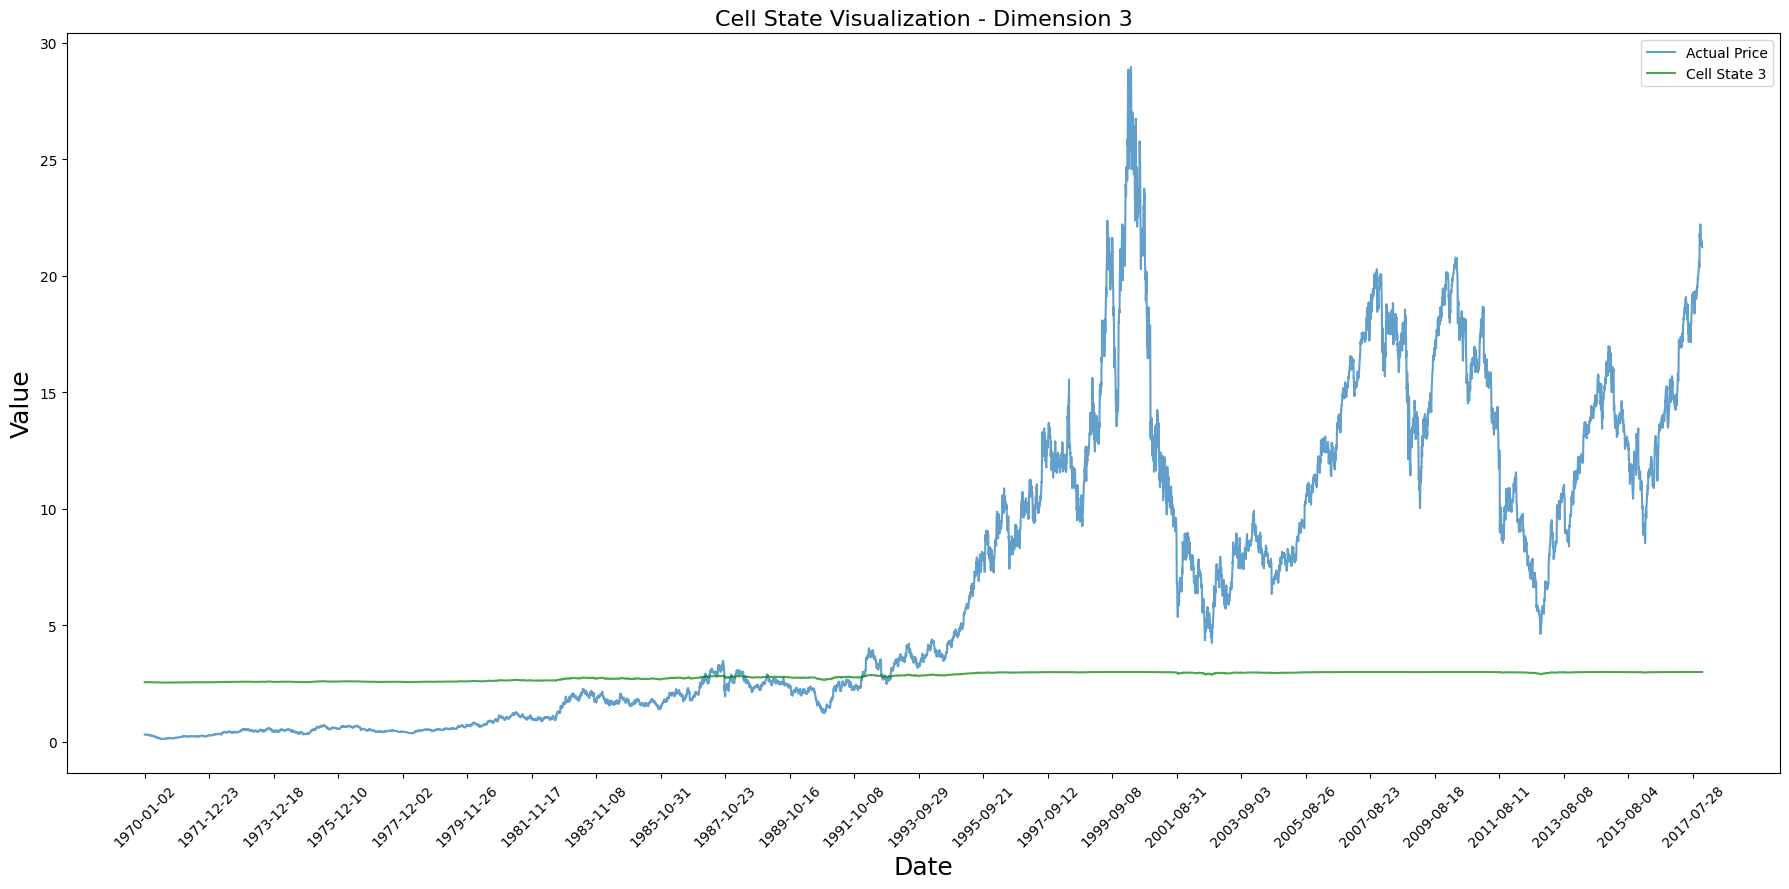

**************************************************************************************************************************************************************
            Estado carry No. 4
**************************************************************************************************************************************************************


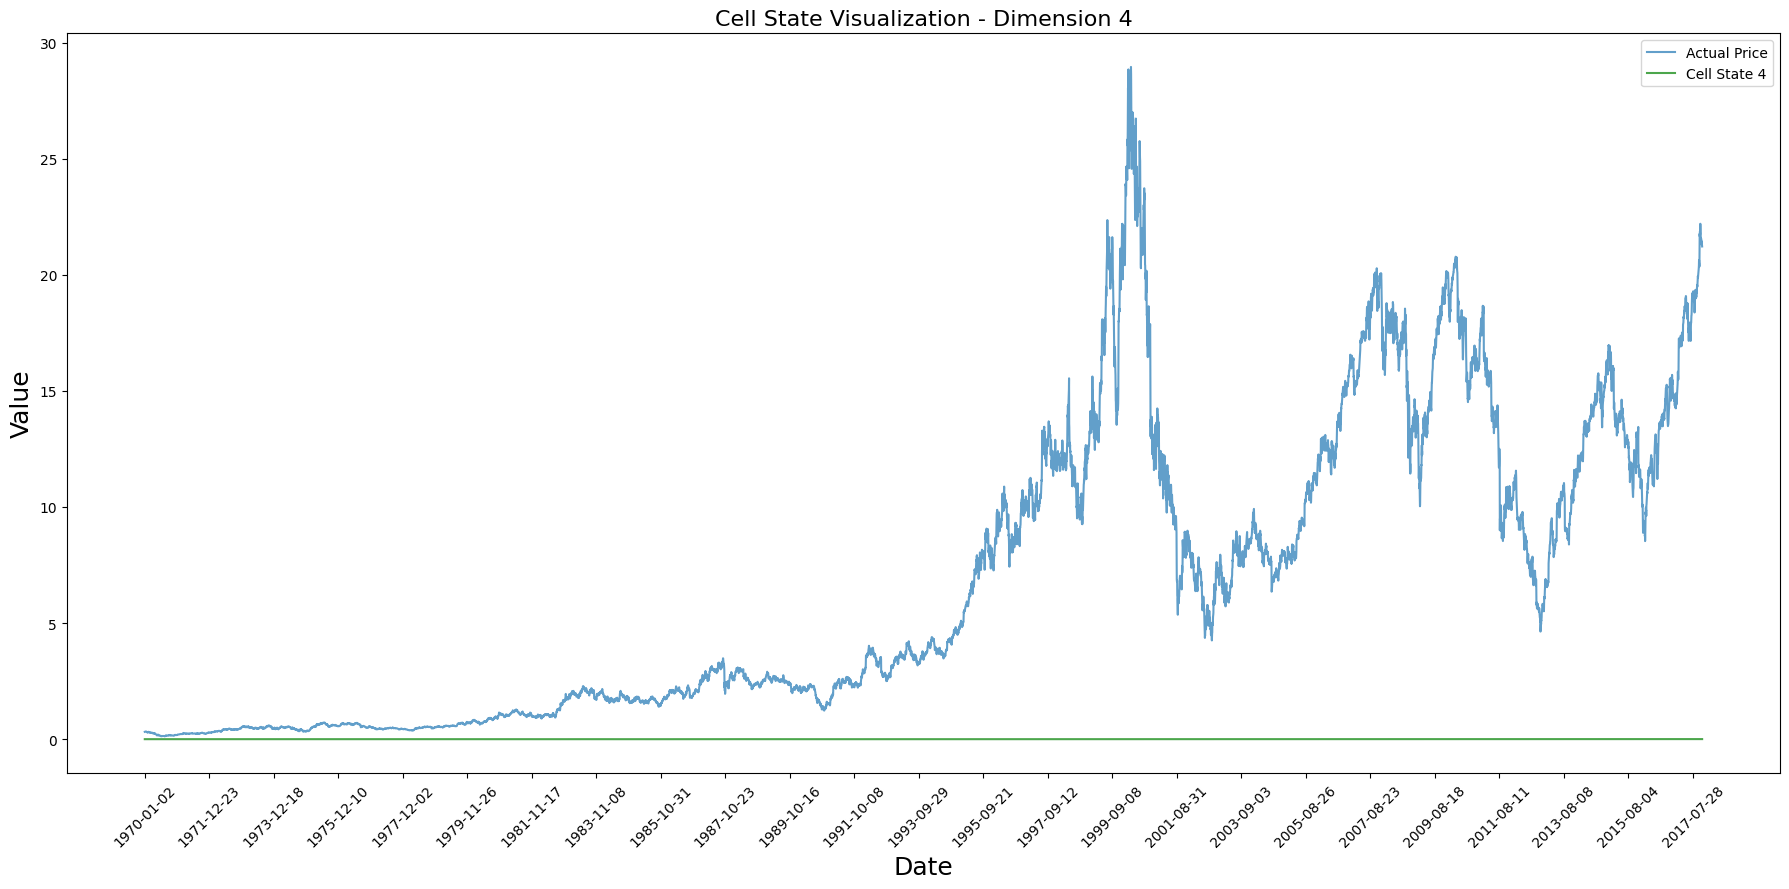

**************************************************************************************************************************************************************
            Estado carry No. 5
**************************************************************************************************************************************************************


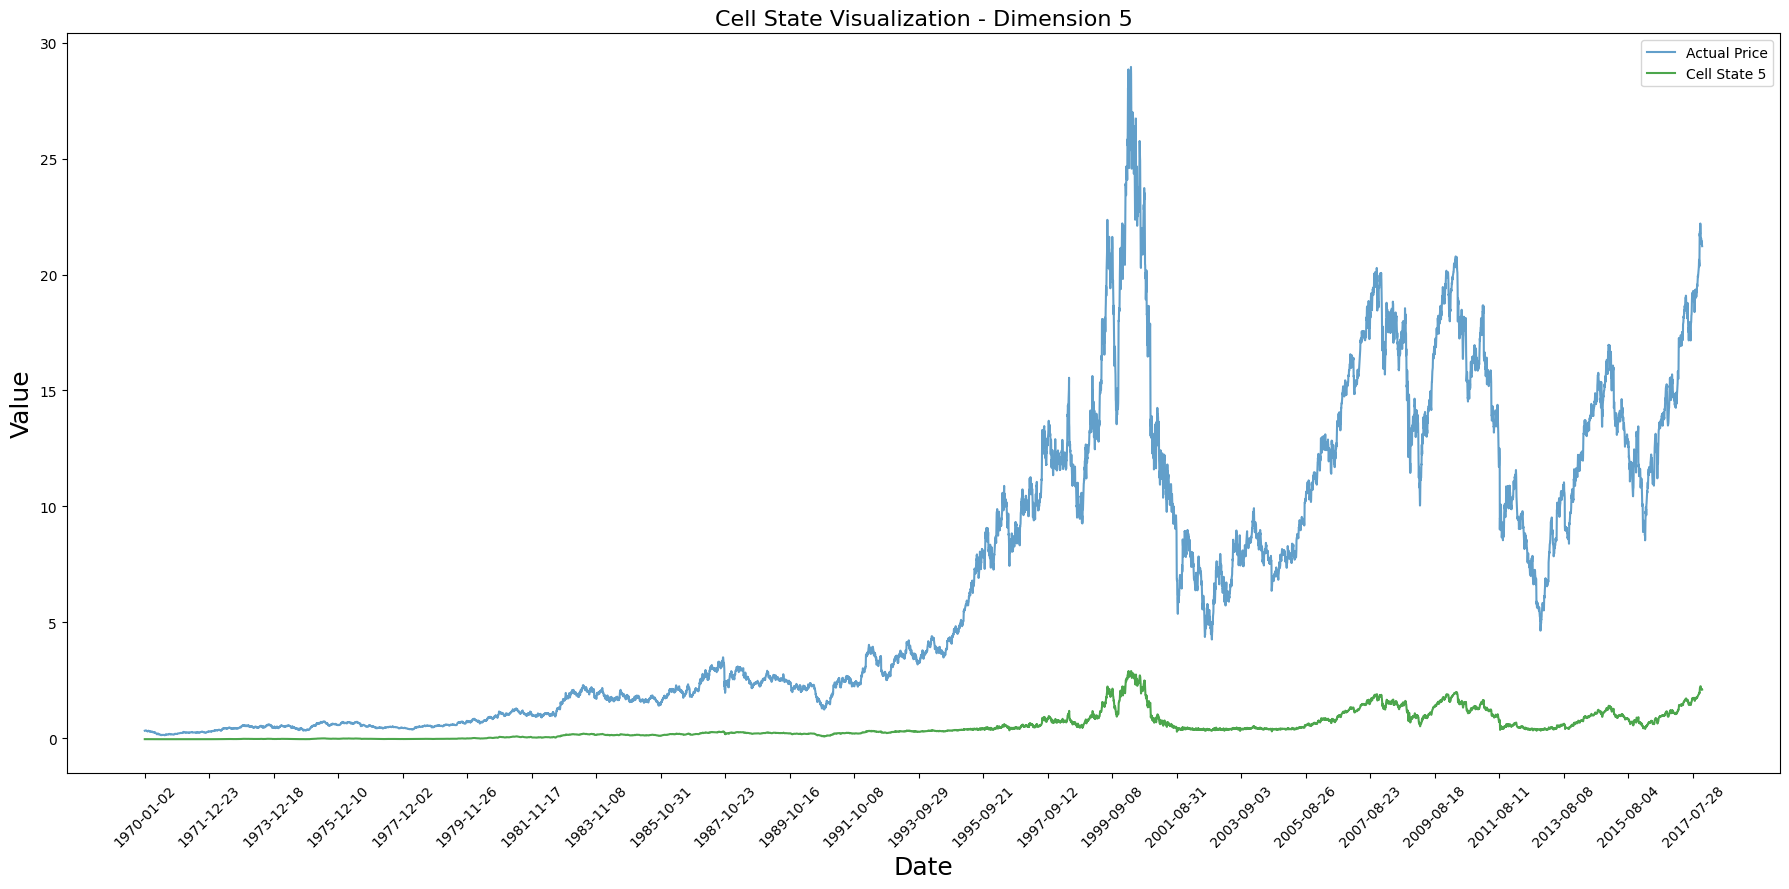

**************************************************************************************************************************************************************
            Estado carry No. 6
**************************************************************************************************************************************************************


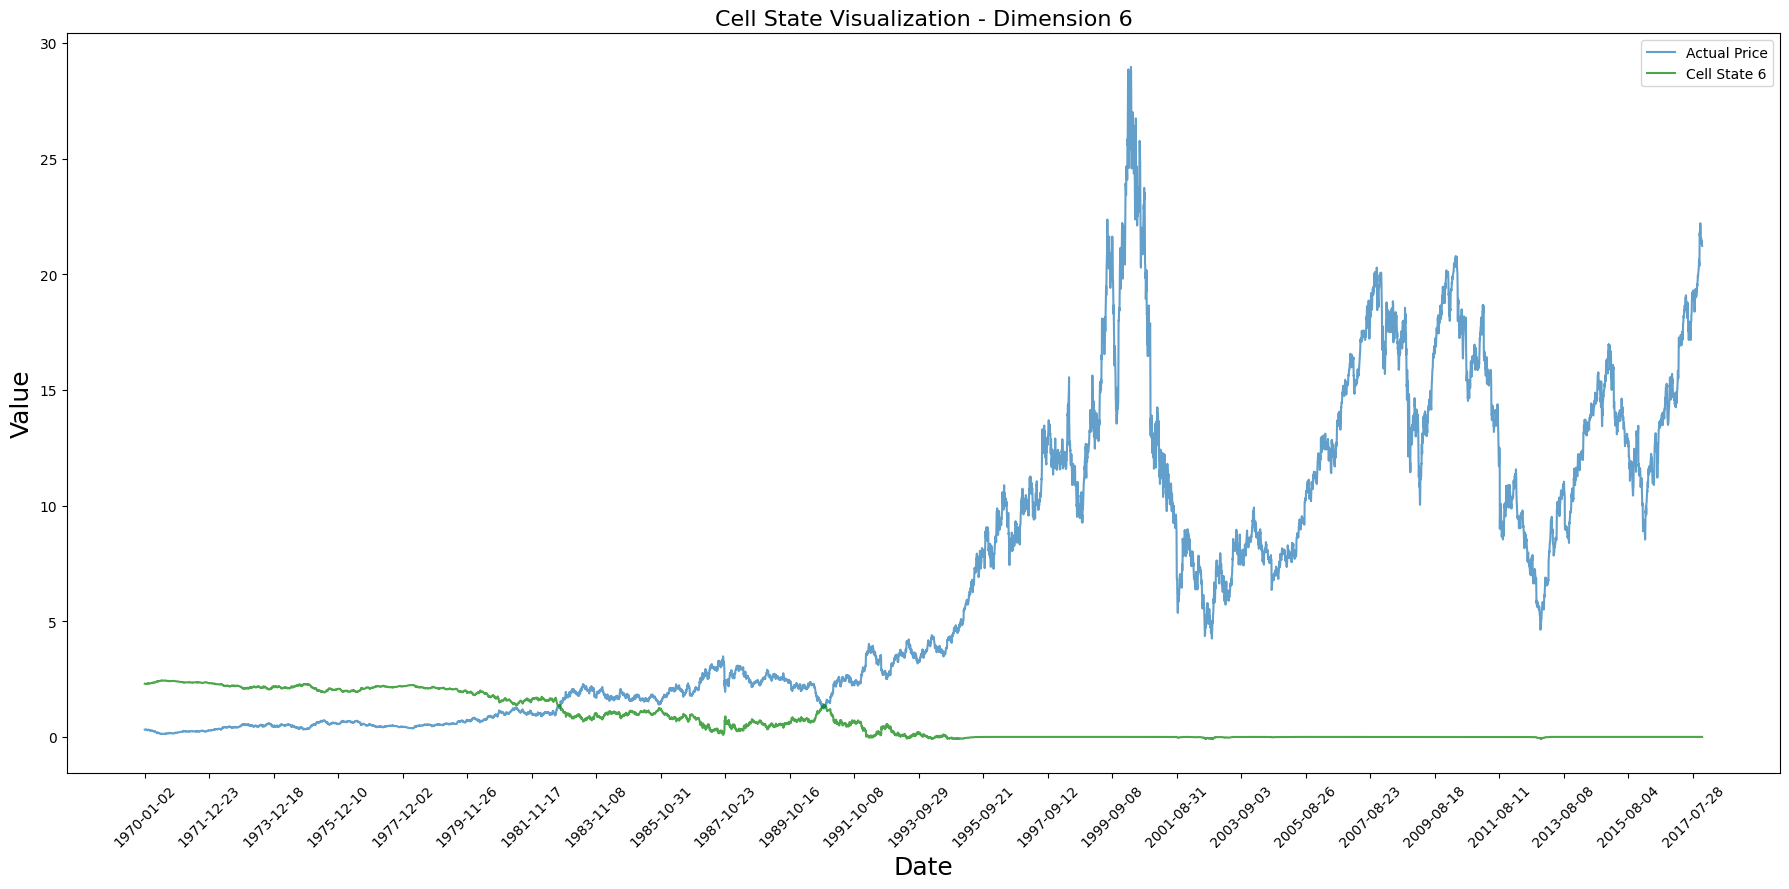

**************************************************************************************************************************************************************
            Estado carry No. 7
**************************************************************************************************************************************************************


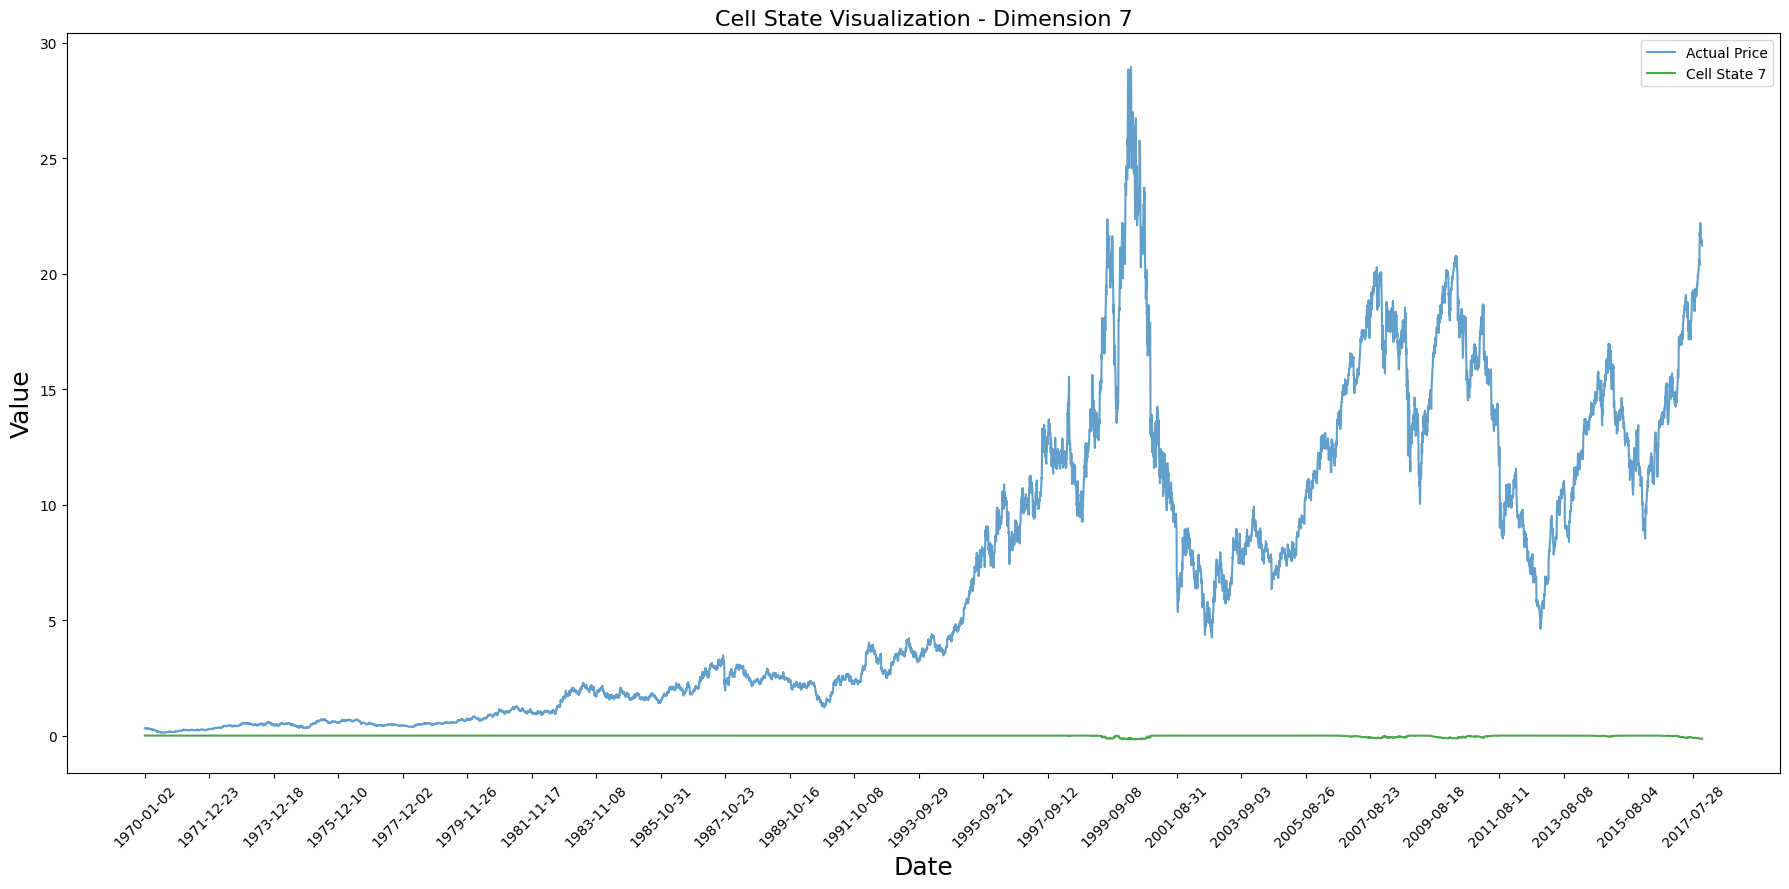

**************************************************************************************************************************************************************
            Estado carry No. 8
**************************************************************************************************************************************************************


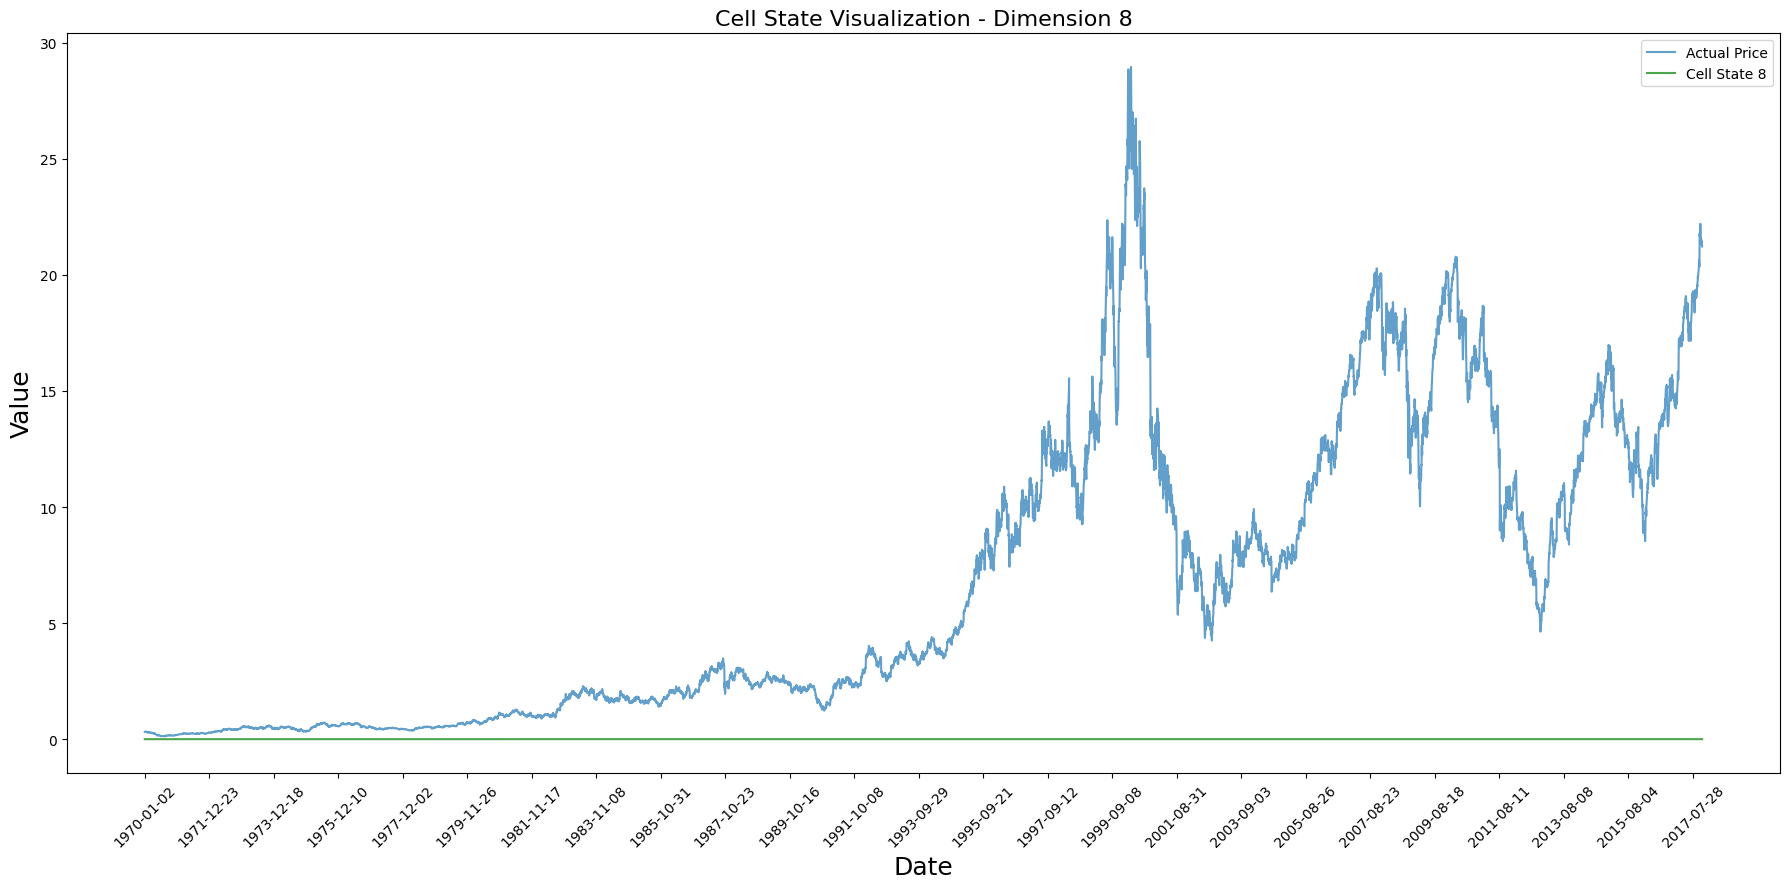

**************************************************************************************************************************************************************
            Estado carry No. 9
**************************************************************************************************************************************************************


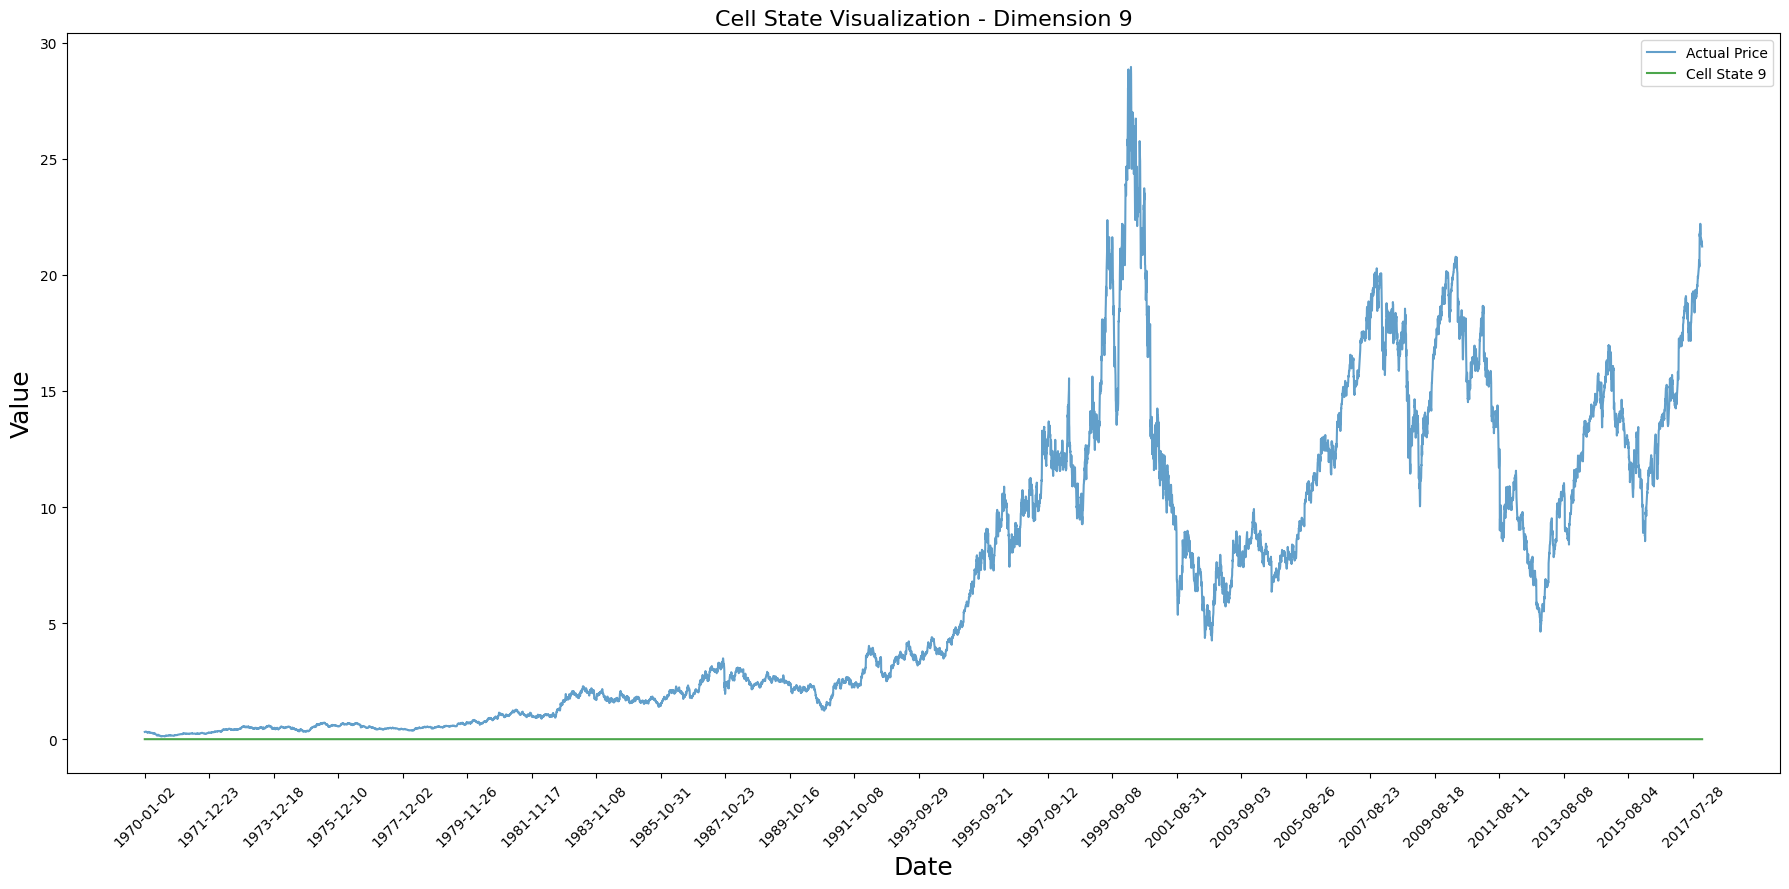

In [ ]:
# Make predictions
print("\nMaking predictions...")
predictions, outputs, hidden_states, cell_states = make_predictions(trained_model, test_loader, device=device)

print(f"Outputs shape: {outputs.shape}")
print(f"Hidden states shape: {hidden_states.shape}")
print(f"Cell states shape: {cell_states.shape}")

# Visualize results
visualize_predictions(predictions, outputs, hidden_states, cell_states, mid_prices, date, hidden_size=10)

# Ahora, hagamos un nuevo entrenamiento pasando como entradaa de la capa densa la concatenacion de los estados C y H de la LSTM (Long-Short Term Memory)


In [ ]:
class LSTMWithCH(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Optional: Add a linear layer to project to single output for prediction
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Forward pass through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0))

        # Get the last output and apply ReLU (like Keras activation="relu")
        last_output = torch.relu(output[:, -1, :])  # Shape: (batch_size, hidden_size)
        final_h = torch.relu(hn[-1])  # Last layer's hidden state with ReLU
        final_c = cn[-1]  # Last layer's cell state (no activation)

        # For prediction, we can use the linear layer or just one dimension
        prediction = self.linear(last_output).squeeze(-1)  # Shape: (batch_size,)

        # Return: prediction, full_output, state_h, state_c
        return prediction, last_output, final_h, final_c